In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.gridspec import GridSpec
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('west_africa_energy_data.csv',  parse_dates=['timestamp'], index_col='timestamp')

In [3]:
df.shape

(657720, 19)

In [4]:
df.head()

,country,demand_mw,price_usd_kwh,outage_risk_score,gdp_usd_billion,inflation_pct,electrification_pct,temp_celsius_mean,humidity_pct,reservoir_level_pct,installed_capacity_mw,available_capacity_mw,transmission_losses_pct,gas_price_usd,diesel_price_usd_liter,fuel_price_index,price_smoothing_factor,capacity_utilization,reserve_margin_pct
timestamp,,,,,,,,,,,,,,,,,,,
2020-01-01,Benin,107.58,0.1261,0.169,17.00,5.00,42.0,22.01,69.48,58.40,600,529.11,18.49,3.578,1.170,86.71,0.997,0.203,391.84
2020-01-01,Burkina Faso,136.81,0.2136,0.231,19.00,5.48,22.0,18.00,72.61,57.53,450,342.48,NaN,5.177,1.227,109.93,0.925,0.399,150.33
2020-01-01,Cape Verde,50.00,0.2198,0.082,2.00,9.98,95.0,18.00,91.22,63.47,180,161.08,15.41,4.474,1.305,103.14,0.975,0.310,222.16
2020-01-01,Ghana,1500.49,0.1296,0.266,77.01,7.64,86.0,19.46,78.34,65.32,5300,4273.40,24.49,3.814,1.078,86.79,0.917,0.351,184.80
2020-01-01,Guinea,155.28,0.1686,0.241,16.00,5.29,45.0,20.41,NaN,52.78,850,646.89,23.27,4.891,1.286,108.08,0.901,0.240,316.59


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 657720 entries, 2020-01-01 00:00:00 to 2024-12-31 23:00:00
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   country                  657720 non-null  object 
 1   demand_mw                657720 non-null  float64
 2   price_usd_kwh            657720 non-null  float64
 3   outage_risk_score        657720 non-null  float64
 4   gdp_usd_billion          657720 non-null  float64
 5   inflation_pct            657720 non-null  float64
 6   electrification_pct      657720 non-null  float64
 7   temp_celsius_mean        618055 non-null  float64
 8   humidity_pct             618469 non-null  float64
 9   reservoir_level_pct      618304 non-null  float64
 10  installed_capacity_mw    657720 non-null  int64  
 11  available_capacity_mw    657720 non-null  float64
 12  transmission_losses_pct  644477 non-null  float64
 13  gas_price_usd            

In [6]:
def handle_missing_values(df):
    """
    Fill missing values using forward fill + backfill.
    Simple and effective for time series.
    """
    df_clean = df.copy()
    
    # Sort by country and time
    df_clean = df_clean.sort_values(['country', 'timestamp']).reset_index(drop=True)
    
    # Forward fill then backfill per country
    df_clean = df_clean.groupby('country').ffill().bfill()
    
    print(f"Missing values: {df_clean.isnull().sum().sum()}")
    
    return df_clean

df_clean = handle_missing_values(df)

Missing values: 0


In [7]:
print(f"   - Time span: {df.index.min()} to {df.index.max()}")
print(f"   - Duration: {(df.index.max() - df.index.min()).days} days")

   - Time span: 2020-01-01 00:00:00 to 2024-12-31 23:00:00
   - Duration: 1826 days


In [8]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
print("Skewness (measure of asymmetry):")
skewness = df[numeric_cols].skew().sort_values(ascending=False)
print(skewness.round(3))

Skewness (measure of asymmetry):
capacity_utilization       23.324
gdp_usd_billion             3.291
demand_mw                   2.920
reserve_margin_pct          1.867
fuel_price_index            1.486
gas_price_usd               1.358
diesel_price_usd_liter      1.159
outage_risk_score           0.624
electrification_pct         0.349
inflation_pct               0.341
temp_celsius_mean           0.090
available_capacity_mw       0.032
installed_capacity_mw       0.003
price_smoothing_factor     -0.000
reservoir_level_pct        -0.007
transmission_losses_pct    -0.070
humidity_pct               -0.234
price_usd_kwh              -0.384
dtype: float64


In [9]:
def time_series_analysis(df):
    """Analyze time series characteristics"""
    print("\n" + "="*80)
    print("8. TIME SERIES PROPERTIES")
    print("="*80)
    
    # Select one country for detailed time series analysis
    country = df['country'].value_counts().index[0]
    country_df = df[df['country'] == country]['demand_mw']
    
    print(f"\n📈 Time Series Analysis for {country}:")
    print("-" * 80)
    
    # Autocorrelation
    print("\n   Autocorrelation at key lags:")
    for lag in [1, 6, 12, 24, 48, 168]:  # 1h, 6h, 12h, 1d, 2d, 1week
        if lag < len(country_df):
            autocorr = country_df.autocorr(lag=lag)
            print(f"      Lag {lag:3d} hours: {autocorr:.4f}")
    
    # Trend analysis
    print("\n   Trend Analysis:")
    first_week = country_df.iloc[:168].mean()
    last_week = country_df.iloc[-168:].mean()
    trend = ((last_week - first_week) / first_week) * 100
    print(f"      First week avg: {first_week:.2f} MW")
    print(f"      Last week avg: {last_week:.2f} MW")
    print(f"      Overall trend: {trend:+.2f}%")
    
    # Volatility
    print("\n   Volatility Analysis:")
    daily_returns = country_df.pct_change().dropna()
    print(f"      Daily volatility: {daily_returns.std():.4f}")
    print(f"      Max daily change: {daily_returns.abs().max():.4f} ({daily_returns.abs().max()*100:.2f}%)")

time_series_analysis(df)


8. TIME SERIES PROPERTIES

📈 Time Series Analysis for Benin:
--------------------------------------------------------------------------------

   Autocorrelation at key lags:
      Lag   1 hours: 0.8974
      Lag   6 hours: 0.3336
      Lag  12 hours: 0.1532
      Lag  24 hours: 0.8763
      Lag  48 hours: 0.8399
      Lag 168 hours: 0.9300

   Trend Analysis:
      First week avg: 172.40 MW
      Last week avg: 219.03 MW
      Overall trend: +27.04%

   Volatility Analysis:
      Daily volatility: 0.1886
      Max daily change: 1.2039 (120.39%)


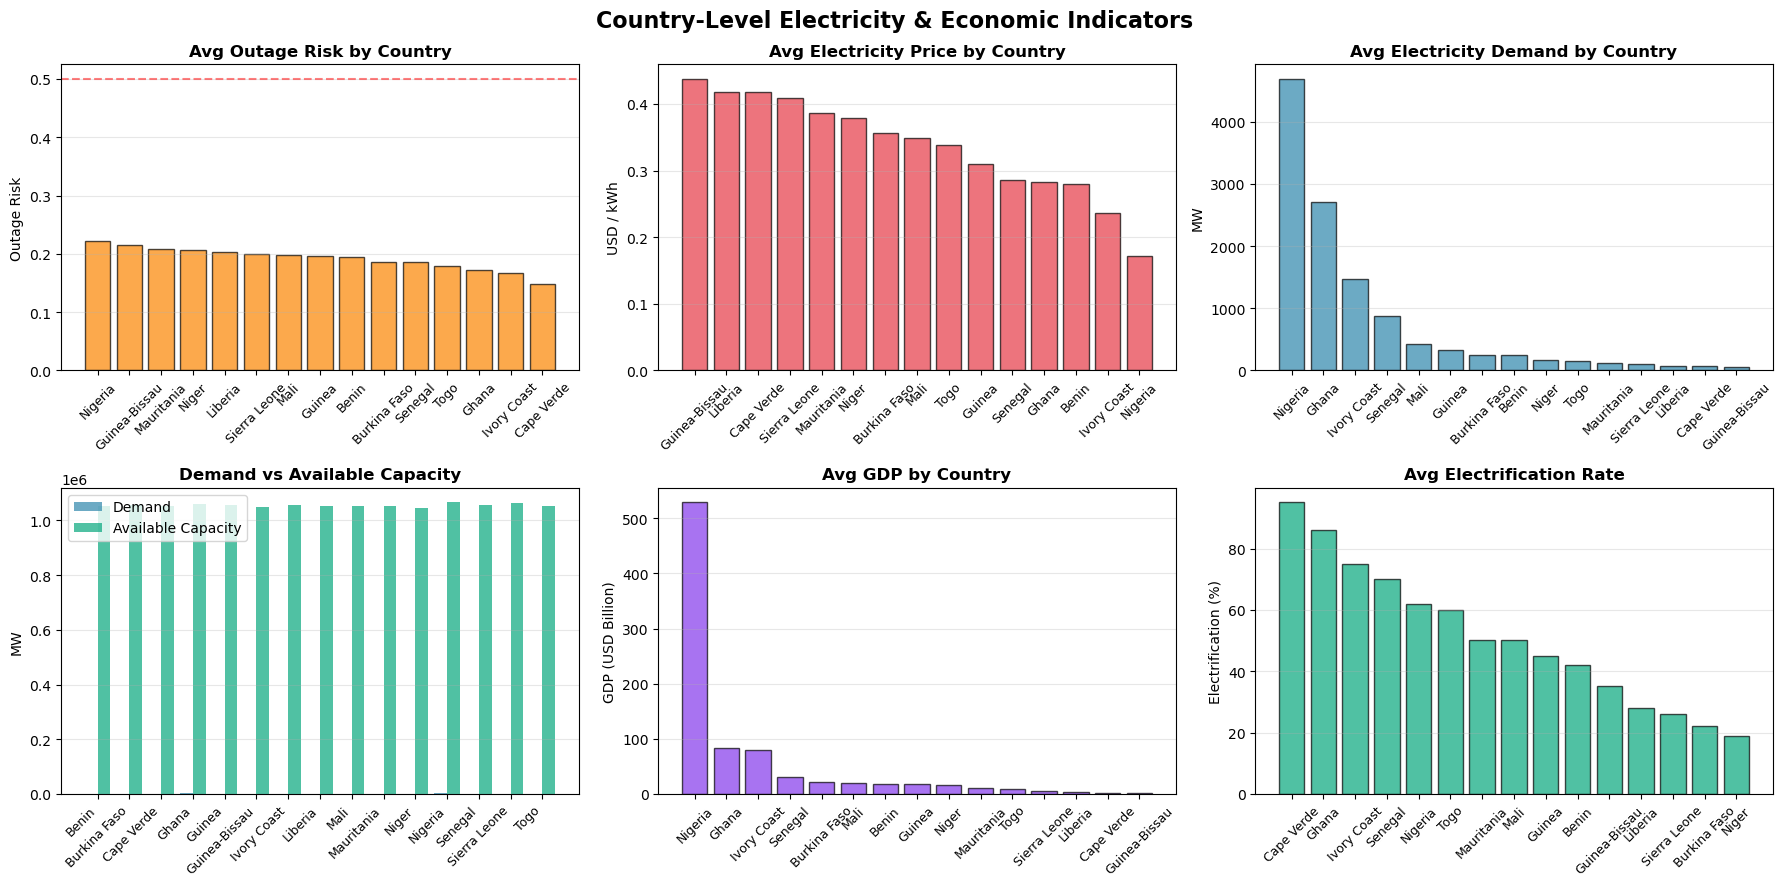

In [10]:
def plot_country_comparisons(df, outage_threshold=0.5):
    """
    Simple country-level comparison plots:
    - Outage risk
    - Price
    - Demand
    - Demand vs Capacity
    - GDP
    - Electrification
    """

    fig, axes = plt.subplots(2, 3, figsize=(18, 9))

    def bar_plot(ax, series, title, ylabel, color):
        series = series.sort_values(ascending=False)
        ax.bar(series.index, series.values, color=color, alpha=0.7, edgecolor='black')
        ax.set_title(title, fontweight='bold')
        ax.set_ylabel(ylabel)
        ax.tick_params(axis='x', rotation=45, labelsize=9)
        ax.grid(axis='y', alpha=0.3)

    # 1️⃣ Outage Risk
    outage = df.groupby('country')['outage_risk_score'].mean()
    bar_plot(axes[0, 0], outage, 'Avg Outage Risk by Country', 'Outage Risk', '#FB8500')
    axes[0, 0].axhline(outage_threshold, color='red', linestyle='--', alpha=0.5)

    # 2️⃣ Price
    price = df.groupby('country')['price_usd_kwh'].mean()
    bar_plot(axes[0, 1], price, 'Avg Electricity Price by Country', 'USD / kWh', '#E63946')

    # 3️⃣ Demand
    demand = df.groupby('country')['demand_mw'].mean()
    bar_plot(axes[0, 2], demand, 'Avg Electricity Demand by Country', 'MW', '#2E86AB')

    # 4️⃣ Demand vs Capacity
    cap = df.groupby('country')[['demand_mw', 'available_capacity_mw']].mean()
    x = np.arange(len(cap))
    w = 0.4
    ax = axes[1, 0]
    ax.bar(x - w/2, cap['demand_mw'], w, label='Demand', color='#2E86AB', alpha=0.7)
    ax.bar(x + w/2, cap['available_capacity_mw'], w, label='Available Capacity', color='#06A77D', alpha=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels(cap.index, rotation=45, ha='right', fontsize=9)
    ax.set_title('Demand vs Available Capacity', fontweight='bold')
    ax.set_ylabel('MW')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    # 5️⃣ GDP
    gdp = df.groupby('country')['gdp_usd_billion'].mean()
    bar_plot(axes[1, 1], gdp, 'Avg GDP by Country', 'GDP (USD Billion)', '#8338EC')

    # 6️⃣ Electrification
    elec = df.groupby('country')['electrification_pct'].mean()
    bar_plot(axes[1, 2], elec, 'Avg Electrification Rate', 'Electrification (%)', '#06A77D')

    plt.suptitle('Country-Level Electricity & Economic Indicators', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


plot_country_comparisons(df)


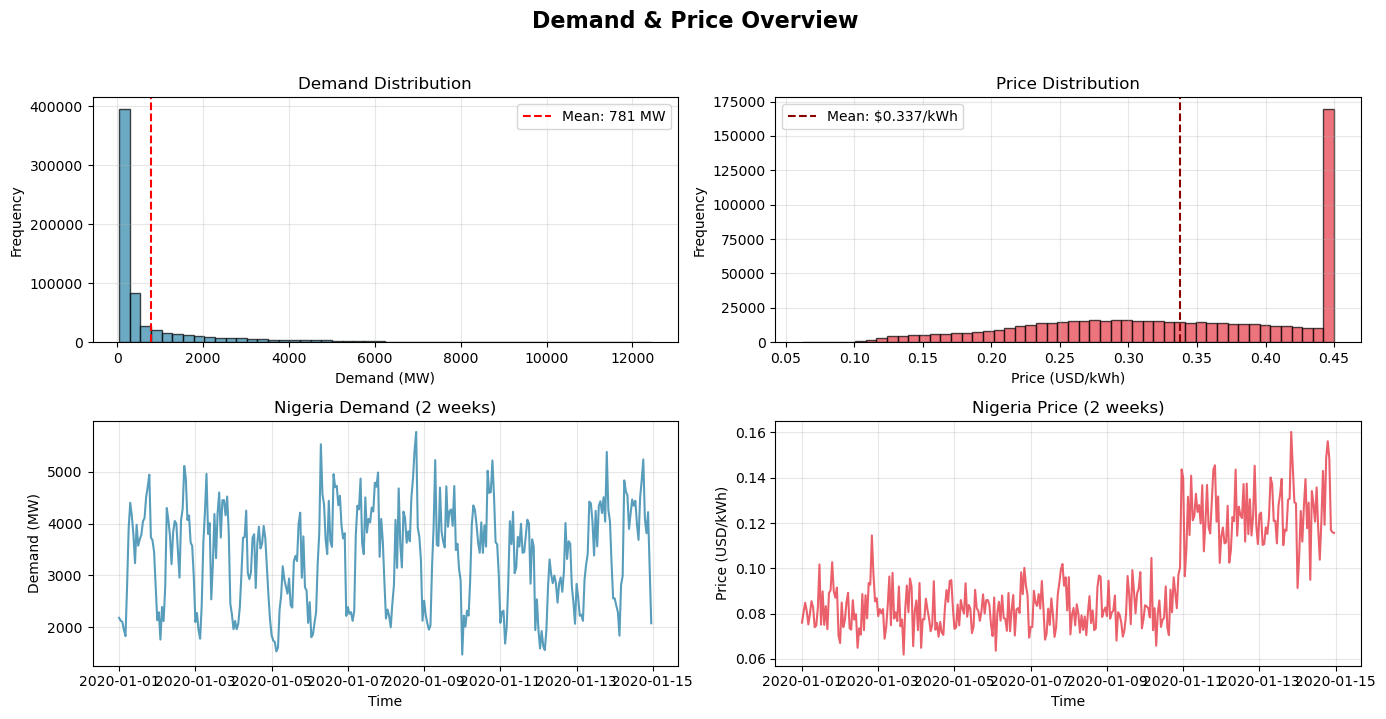

In [11]:
def plot_targets_overview(df):
    """Quick overview of demand and price distributions and short Nigeria time series"""

    fig, axes = plt.subplots(2, 2, figsize=(14, 7))

    # ---- Demand distribution ----
    axes[0, 0].hist(df['demand_mw'], bins=50, color='#2E86AB', alpha=0.7, edgecolor='black')
    axes[0, 0].axvline(df['demand_mw'].mean(), color='red', linestyle='--',
                       label=f"Mean: {df['demand_mw'].mean():.0f} MW")
    axes[0, 0].set_xlabel('Demand (MW)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Demand Distribution')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)

    # ---- Price distribution ----
    axes[0, 1].hist(df['price_usd_kwh'], bins=50, color='#E63946', alpha=0.7, edgecolor='black')
    axes[0, 1].axvline(df['price_usd_kwh'].mean(), color='darkred', linestyle='--',
                       label=f"Mean: ${df['price_usd_kwh'].mean():.3f}/kWh")
    axes[0, 1].set_xlabel('Price (USD/kWh)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Price Distribution')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)

    # ---- Nigeria demand time series (2 weeks) ----
    nigeria_demand = df[df['country'] == 'Nigeria']['demand_mw']
    axes[1, 0].plot(nigeria_demand.index[:168*2], nigeria_demand.values[:168*2],
                    color='#2E86AB', alpha=0.8)
    axes[1, 0].set_xlabel('Time')
    axes[1, 0].set_ylabel('Demand (MW)')
    axes[1, 0].set_title('Nigeria Demand (2 weeks)')
    axes[1, 0].grid(alpha=0.3)

    # ---- Nigeria price time series (2 weeks) ----
    nigeria_price = df[df['country'] == 'Nigeria']['price_usd_kwh']
    axes[1, 1].plot(nigeria_price.index[:168*2], nigeria_price.values[:168*2],
                    color='#E63946', alpha=0.8)
    axes[1, 1].set_xlabel('Time')
    axes[1, 1].set_ylabel('Price (USD/kWh)')
    axes[1, 1].set_title('Nigeria Price (2 weeks)')
    axes[1, 1].grid(alpha=0.3)

    plt.suptitle('Demand & Price Overview', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

plot_targets_overview(df)

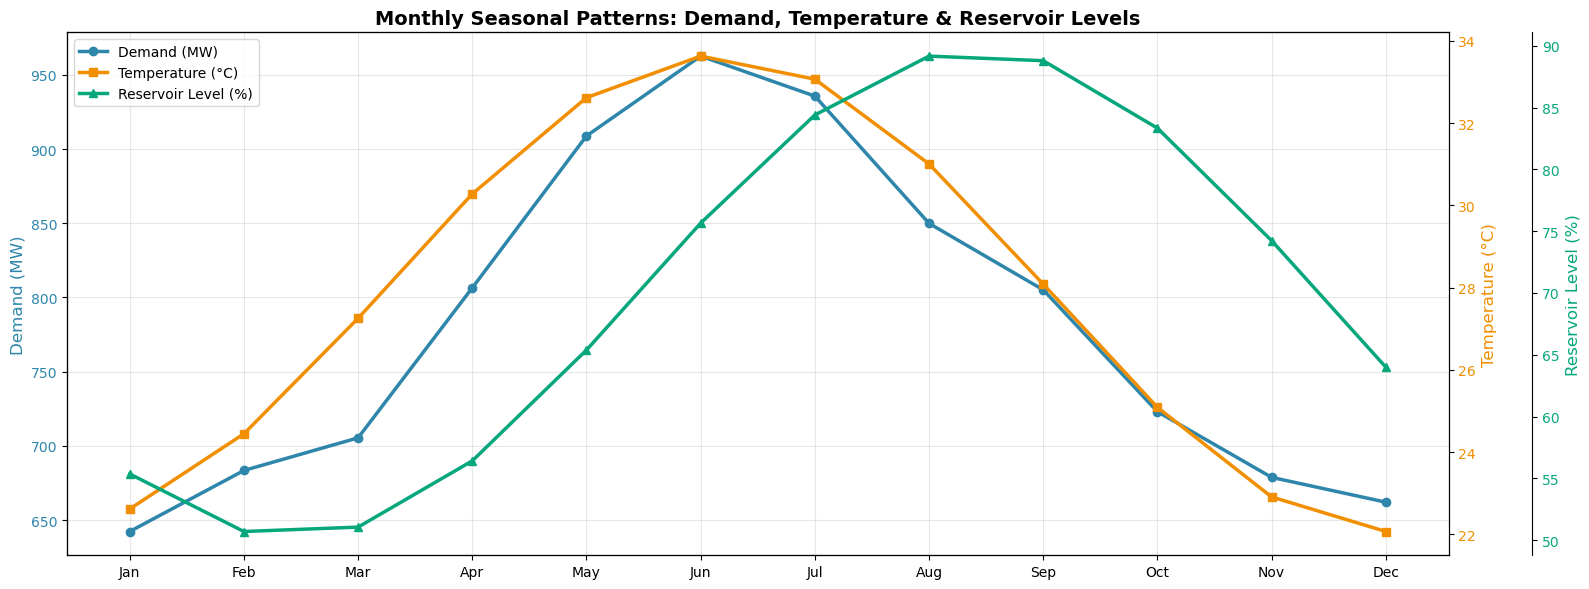

In [12]:
def plot_monthly_seasonal_patterns(df):
    """
    Plot monthly seasonal patterns of:
    1. Demand (MW)
    2. Temperature (°C)
    3. Reservoir Level (%)
    """
    # Ensure timestamp is datetime and set as index
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.set_index('timestamp', inplace=True)

    # Aggregate monthly averages
    monthly_stats = df.groupby(df.index.month).agg({
        'demand_mw': 'mean',
        'temp_celsius_mean': 'mean',
        'reservoir_level_pct': 'mean'
    })

    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    fig, ax1 = plt.subplots(figsize=(16, 6))

    # Primary y-axis: Demand
    p1, = ax1.plot(months, monthly_stats['demand_mw'], marker='o',
                   color='#2E86AB', linewidth=2.5, label='Demand (MW)')
    ax1.set_ylabel('Demand (MW)', color='#2E86AB', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='#2E86AB')

    # Secondary y-axis: Temperature
    ax2 = ax1.twinx()
    p2, = ax2.plot(months, monthly_stats['temp_celsius_mean'], marker='s',
                   color='#F18F01', linewidth=2.5, label='Temperature (°C)')
    ax2.set_ylabel('Temperature (°C)', color='#F18F01', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='#F18F01')

    # Third y-axis: Reservoir Level
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    p3, = ax3.plot(months, monthly_stats['reservoir_level_pct'], marker='^',
                   color='#06A77D', linewidth=2.5, label='Reservoir Level (%)')
    ax3.set_ylabel('Reservoir Level (%)', color='#06A77D', fontsize=12)
    ax3.tick_params(axis='y', labelcolor='#06A77D')

    # Title, grid, legend
    ax1.set_title('Monthly Seasonal Patterns: Demand, Temperature & Reservoir Levels',
                  fontsize=14, fontweight='bold')
    ax1.grid(alpha=0.3)

    lines = [p1, p2, p3]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left')

    plt.tight_layout()
    plt.show()

plot_monthly_seasonal_patterns(df)


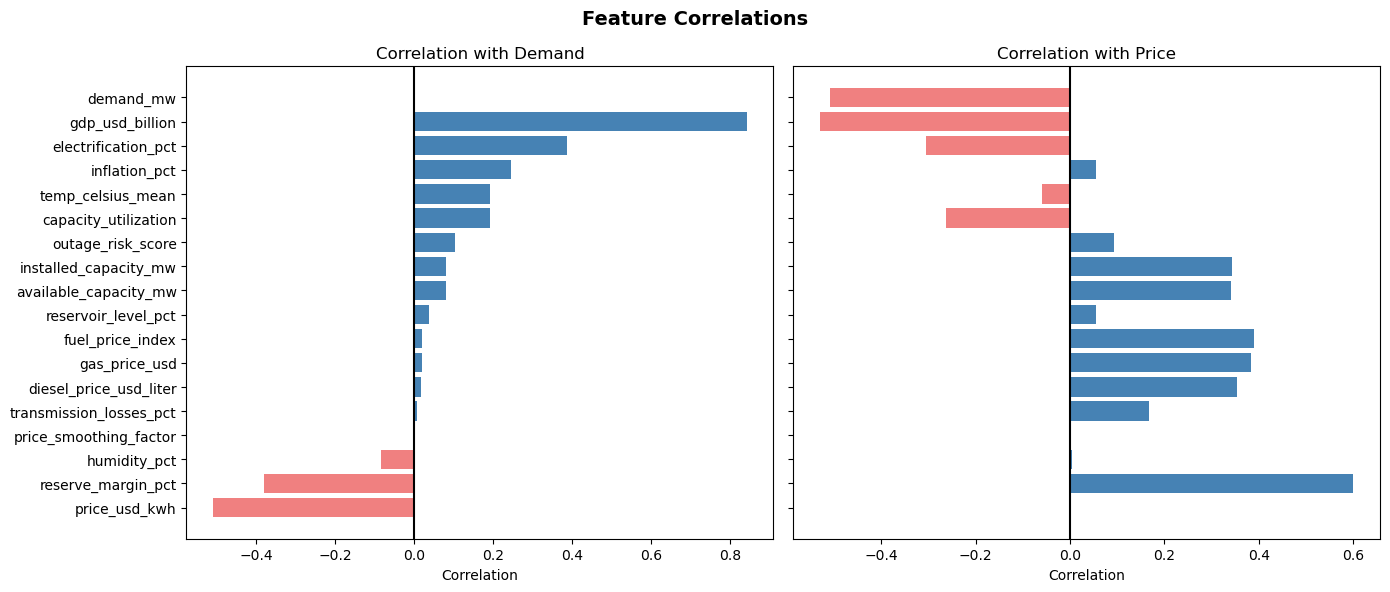

In [13]:
def plot_demand_price_correlations(df):
    import numpy as np
    import matplotlib.pyplot as plt

    numeric_df = df.select_dtypes(include=np.number)
    corr = numeric_df.corr()

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # ---- Demand correlations ----
    demand_vals = corr['demand_mw'].drop('demand_mw').sort_values()
    demand_colors = np.where(demand_vals < 0, 'lightcoral', 'steelblue')

    axes[0].barh(demand_vals.index, demand_vals.values, color=demand_colors)
    axes[0].axvline(0, color='black')
    axes[0].set_title('Correlation with Demand')
    axes[0].set_xlabel('Correlation')

    # ---- Price correlations ----
    price_vals = corr['price_usd_kwh'].drop('price_usd_kwh').sort_values()
    price_colors = np.where(price_vals < 0, 'lightcoral', 'steelblue')

    axes[1].barh(price_vals.index, price_vals.values, color=price_colors)
    axes[1].axvline(0, color='black')
    axes[1].set_title('Correlation with Price')
    axes[1].set_xlabel('Correlation')

    plt.suptitle('Feature Correlations', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
plot_demand_price_correlations(df)


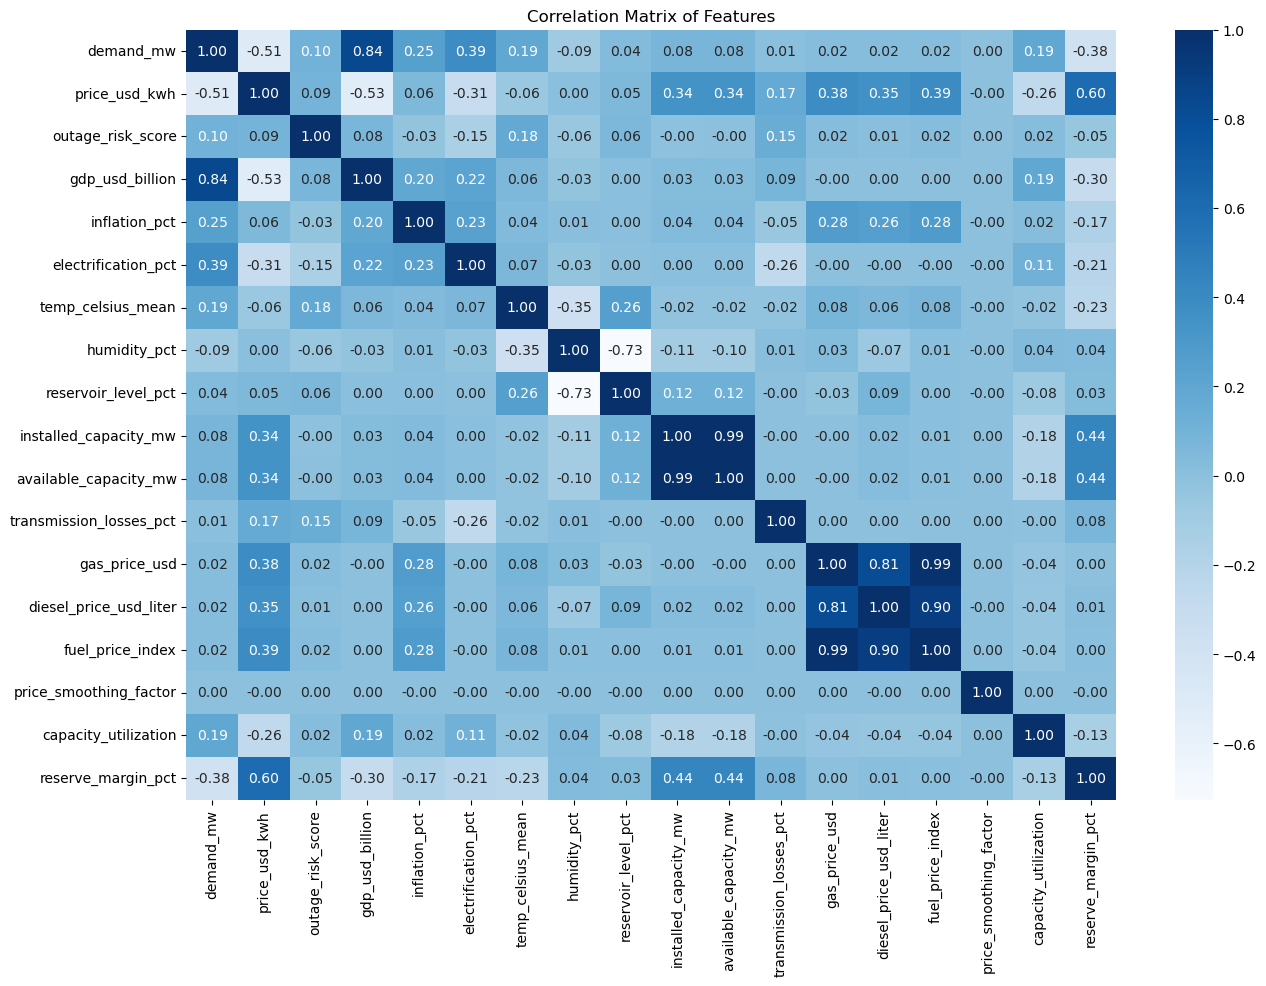

In [14]:
numerical_cols = df.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(15,10))
sns.heatmap(numerical_cols.corr(), annot=True, fmt='.2f', cmap='Blues')
plt.title('Correlation Matrix of Features')
plt.show()

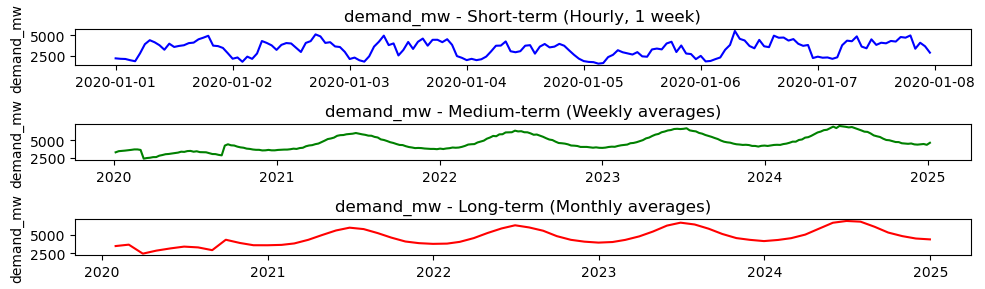

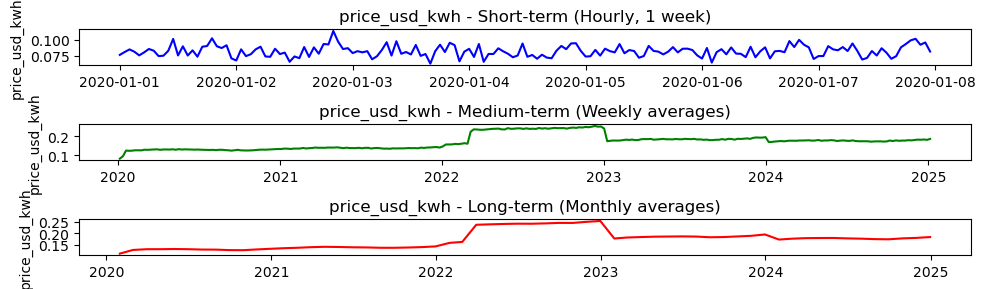

In [15]:
def plot_temporal_patterns(df, target_col, country='Nigeria'):
    """
    Plots short-term (hourly), medium-term (weekly), and long-term (monthly) temporal patterns
    for a given target variable (demand or price).
    """
    df_country = df[df['country'] == country].copy()
    
    # Ensure datetime index
    if not isinstance(df_country.index, pd.DatetimeIndex):
        df_country['timestamp'] = pd.to_datetime(df_country['timestamp'])
        df_country = df_country.set_index('timestamp')
    
    # Short-term: Hourly pattern over a few days
    short_term = df_country[target_col].iloc[:24*7]  # first week
    # Medium-term: Weekly average pattern
    medium_term = df_country[target_col].resample('W').mean()
    # Long-term: Monthly average pattern
    long_term = df_country[target_col].resample('M').mean()
    
    # Plot
    fig, axes = plt.subplots(3, 1, figsize=(10, 3))
    
    axes[0].plot(short_term.index, short_term.values, color='blue')
    axes[0].set_title(f"{target_col} - Short-term (Hourly, 1 week)")
    axes[0].set_ylabel(target_col)
    
    axes[1].plot(medium_term.index, medium_term.values, color='green')
    axes[1].set_title(f"{target_col} - Medium-term (Weekly averages)")
    axes[1].set_ylabel(target_col)
    
    axes[2].plot(long_term.index, long_term.values, color='red')
    axes[2].set_title(f"{target_col} - Long-term (Monthly averages)")
    axes[2].set_ylabel(target_col)
    
    plt.tight_layout()
    plt.show()
# Plot temporal patterns for demand
plot_temporal_patterns(df, 'demand_mw', country='Nigeria')
# Plot temporal patterns for price
plot_temporal_patterns(df, 'price_usd_kwh', country='Nigeria')

In [16]:
df.insert(1, 'weekofyear', df.index.isocalendar().week.astype(int))

In [17]:
df['hour'] = df.index.hour

In [18]:
df.insert(1, 'hour', df.pop('hour'))

In [19]:
df['year'] = df.index.year
df.insert(2, 'year', df.pop('year'))

In [20]:
df['month'] = df.index.month
df.insert(2, 'month', df.pop('month'))

In [21]:
df.head()

,country,hour,month,year,weekofyear,demand_mw,price_usd_kwh,outage_risk_score,gdp_usd_billion,inflation_pct,...,reservoir_level_pct,installed_capacity_mw,available_capacity_mw,transmission_losses_pct,gas_price_usd,diesel_price_usd_liter,fuel_price_index,price_smoothing_factor,capacity_utilization,reserve_margin_pct
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01,Benin,0,1,2020,1,107.58,0.1261,0.169,17.00,5.00,...,58.40,600,529.11,18.49,3.578,1.170,86.71,0.997,0.203,391.84
2020-01-01,Burkina Faso,0,1,2020,1,136.81,0.2136,0.231,19.00,5.48,...,57.53,450,342.48,NaN,5.177,1.227,109.93,0.925,0.399,150.33
2020-01-01,Cape Verde,0,1,2020,1,50.00,0.2198,0.082,2.00,9.98,...,63.47,180,161.08,15.41,4.474,1.305,103.14,0.975,0.310,222.16
2020-01-01,Ghana,0,1,2020,1,1500.49,0.1296,0.266,77.01,7.64,...,65.32,5300,4273.40,24.49,3.814,1.078,86.79,0.917,0.351,184.80
2020-01-01,Guinea,0,1,2020,1,155.28,0.1686,0.241,16.00,5.29,...,52.78,850,646.89,23.27,4.891,1.286,108.08,0.901,0.240,316.59


In [22]:
df.insert(1, 'is_weeknd', df.index.dayofweek.isin([5,6]))

In [23]:
df['is_weeknd'] = df['is_weeknd'].astype(int)

In [24]:
df.head()

,country,is_weeknd,hour,month,year,weekofyear,demand_mw,price_usd_kwh,outage_risk_score,gdp_usd_billion,...,reservoir_level_pct,installed_capacity_mw,available_capacity_mw,transmission_losses_pct,gas_price_usd,diesel_price_usd_liter,fuel_price_index,price_smoothing_factor,capacity_utilization,reserve_margin_pct
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01,Benin,0,0,1,2020,1,107.58,0.1261,0.169,17.00,...,58.40,600,529.11,18.49,3.578,1.170,86.71,0.997,0.203,391.84
2020-01-01,Burkina Faso,0,0,1,2020,1,136.81,0.2136,0.231,19.00,...,57.53,450,342.48,NaN,5.177,1.227,109.93,0.925,0.399,150.33
2020-01-01,Cape Verde,0,0,1,2020,1,50.00,0.2198,0.082,2.00,...,63.47,180,161.08,15.41,4.474,1.305,103.14,0.975,0.310,222.16
2020-01-01,Ghana,0,0,1,2020,1,1500.49,0.1296,0.266,77.01,...,65.32,5300,4273.40,24.49,3.814,1.078,86.79,0.917,0.351,184.80
2020-01-01,Guinea,0,0,1,2020,1,155.28,0.1686,0.241,16.00,...,52.78,850,646.89,23.27,4.891,1.286,108.08,0.901,0.240,316.59


Lag features answer:

“What happened exactly X time ago?”

Rolling features answer:

“What has been happening on average recently?”

In [25]:
df.shape

(657720, 24)

In [26]:
def feature_engineering(df):
    """
    Create lagged, rolling, and key interaction features for electricity demand and price modeling.
    Includes stress indicators like load ratio and capacity margin.
    """
    df = df.sort_values(['country', 'timestamp']).copy()
    grouped = df.groupby('country')
    
    #Lag Features
    df['demand_lag_1h'] = grouped['demand_mw'].shift(1)
    df['demand_lag_24h'] = grouped['demand_mw'].shift(24)
    df['demand_lag_168h'] = grouped['demand_mw'].shift(168)
    
    df['temp_lag_1d'] = grouped['temp_celsius_mean'].shift(1)
    df['temp_lag_7d'] = grouped['temp_celsius_mean'].shift(3)
    
    df['price_lag_1h'] = grouped['price_usd_kwh'].shift(1)
    df['price_lag_24h'] = grouped['price_usd_kwh'].shift(24)
    
    df['capacity_lag_1d'] = grouped['available_capacity_mw'].shift(1)
    df['capacity_lag_7d'] = grouped['available_capacity_mw'].shift(7)

    #Rolling Features
    df['demand_roll_mean_7d'] = grouped['demand_mw'].transform(
        lambda x: x.rolling(7, min_periods=1).mean()
    )
    df['demand_roll_std_7d'] = grouped['demand_mw'].transform(
        lambda x: x.rolling(7, min_periods=1).std()
    )
    df['demand_roll_mean_30d'] = grouped['demand_mw'].transform(
        lambda x: x.rolling(30, min_periods=1).mean()
    )
    
    df['temp_roll_mean_7d'] = grouped['temp_celsius_mean'].transform(
        lambda x: x.rolling(7, min_periods=1).mean()
    )
    df['temp_roll_max_7d'] = grouped['temp_celsius_mean'].transform(
        lambda x: x.rolling(7, min_periods=1).max()
    )
    
    df['price_roll_mean_7d'] = grouped['price_usd_kwh'].transform(
        lambda x: x.rolling(7, min_periods=1).mean()
    )
    df['price_roll_std_7d'] = grouped['price_usd_kwh'].transform(
        lambda x: x.rolling(7, min_periods=1).std()
    )
    df['price_roll_mean_30d'] = grouped['price_usd_kwh'].transform(
        lambda x: x.rolling(30, min_periods=1).mean()
    )
    
    df['capacity_roll_mean_7d'] = grouped['available_capacity_mw'].transform(
        lambda x: x.rolling(7, min_periods=1).mean()
    )
    df['capacity_roll_mean_30d'] = grouped['available_capacity_mw'].transform(
        lambda x: x.rolling(30, min_periods=1).mean()
    )
    
    df['load_ratio'] = df['demand_mw'] / df['available_capacity_mw'] 
    # Load ratio (scarcity indicator)
    # Interpretation:
    # < 0.7 → comfortable
    # ~ 1.0 → dangerous
    # > 1.0 → blackouts likely
    df['capacity_margin'] = df['available_capacity_mw'] - df['demand_mw'] #unmet demand
    df['load_ratio_lag_1'] = grouped['load_ratio'].shift(1)
    #interaction features
    df['temp_gdp_interaction'] = df['temp_celsius_mean'] * df['gdp_usd_billion']
    # df['price_inflation_stress'] = df['price_roll_std_7d'] * df['inflation_pct']
    
    df = df.dropna()
    
    return df

temp_gdp_interaction = temperature × GDP

Hot days in richer countries → higher electricity demand (more AC use).

price_inflation_stress = price volatility × inflation

High price swings + high inflation → economic stress → higher/unstable electricity prices.

Rolling std for demand and price captures volatility

In [27]:
df = feature_engineering(df)

In [28]:
df.shape

(471399, 47)

In [29]:
df.head()

,country,is_weeknd,hour,month,year,weekofyear,demand_mw,price_usd_kwh,outage_risk_score,gdp_usd_billion,...,temp_roll_max_7d,price_roll_mean_7d,price_roll_std_7d,price_roll_mean_30d,capacity_roll_mean_7d,capacity_roll_mean_30d,load_ratio,capacity_margin,load_ratio_lag_1,temp_gdp_interaction
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-08 00:00:00,Benin,0,0,1,2020,2,118.63,0.1603,0.167,17.01,...,23.53,0.155943,0.012190,0.146863,8053.017143,7865.651333,0.014604,8004.60,0.019273,400.2453
2020-01-08 01:00:00,Benin,0,1,1,2020,2,120.52,0.1326,0.068,17.01,...,23.53,0.151543,0.014407,0.146480,8143.337143,7900.653333,0.013498,8807.93,0.014604,332.5455
2020-01-08 02:00:00,Benin,0,2,1,2020,2,91.71,0.1290,0.176,17.01,...,23.53,0.148657,0.016782,0.145090,8233.498571,7939.908333,0.011333,8000.50,0.013498,372.8592
2020-01-08 03:00:00,Benin,0,3,1,2020,2,115.86,0.1436,0.220,17.01,...,23.53,0.144943,0.014025,0.144273,8243.790000,8010.757667,0.013146,8697.31,0.011333,363.5037
2020-01-08 04:00:00,Benin,0,4,1,2020,2,121.66,0.1419,0.094,17.01,...,23.53,0.141800,0.011261,0.143653,8355.718571,8078.759333,0.013832,8673.60,0.013146,394.9722


In [30]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from prophet import Prophet
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [31]:
target_demand = 'demand_mw'
target_price = 'price_usd_kwh'

In [32]:
feature_cols = df.drop(['country', 'demand_mw', 'price_usd_kwh'], axis=1)

In [33]:
le = LabelEncoder()
df['country_encoded'] = le.fit_transform(df['country'])
feature_cols = list(feature_cols.columns)
feature_cols.append('country_encoded')

In [34]:
X = df[feature_cols].copy()
y_demand = df[target_demand].copy()
y_price = df[target_price].copy()

In [35]:
df.head()

,country,is_weeknd,hour,month,year,weekofyear,demand_mw,price_usd_kwh,outage_risk_score,gdp_usd_billion,...,price_roll_mean_7d,price_roll_std_7d,price_roll_mean_30d,capacity_roll_mean_7d,capacity_roll_mean_30d,load_ratio,capacity_margin,load_ratio_lag_1,temp_gdp_interaction,country_encoded
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-08 00:00:00,Benin,0,0,1,2020,2,118.63,0.1603,0.167,17.01,...,0.155943,0.012190,0.146863,8053.017143,7865.651333,0.014604,8004.60,0.019273,400.2453,0
2020-01-08 01:00:00,Benin,0,1,1,2020,2,120.52,0.1326,0.068,17.01,...,0.151543,0.014407,0.146480,8143.337143,7900.653333,0.013498,8807.93,0.014604,332.5455,0
2020-01-08 02:00:00,Benin,0,2,1,2020,2,91.71,0.1290,0.176,17.01,...,0.148657,0.016782,0.145090,8233.498571,7939.908333,0.011333,8000.50,0.013498,372.8592,0
2020-01-08 03:00:00,Benin,0,3,1,2020,2,115.86,0.1436,0.220,17.01,...,0.144943,0.014025,0.144273,8243.790000,8010.757667,0.013146,8697.31,0.011333,363.5037,0
2020-01-08 04:00:00,Benin,0,4,1,2020,2,121.66,0.1419,0.094,17.01,...,0.141800,0.011261,0.143653,8355.718571,8078.759333,0.013832,8673.60,0.013146,394.9722,0


In [36]:
def time_series_split(X, y_demand, y_price, train_size=0.7, val_size=0.15):
    """Splitting time series data chronologically"""
    n = len(X)
    train = int(n * train_size)
    val = int(n* (train_size + val_size))
    
    X_train = X.iloc[:train]
    X_val = X.iloc[train:val]
    X_test = X.iloc[val:]

    y_demand_train = y_demand.iloc[:train]
    y_demand_val = y_demand.iloc[train:val]
    y_demand_test = y_demand.iloc[val:]

    y_price_train = y_price.iloc[:train]
    y_price_val = y_price.iloc[train:val]
    y_price_test = y_price.iloc[val:]

    print(f'Train: {len(X_train):,} samples')
    print(f'Validation: {len(X_val):,} samples')
    print(f'Test: {len(X_test):,} samples')

    return (X_train, X_val, X_test, y_demand_train, y_demand_val, y_demand_test, y_price_train, y_price_val, y_price_test)

(
    X_train, X_val, X_test,
    y_demand_train, y_demand_val, y_demand_test,
    y_price_train, y_price_val, y_price_test
) = time_series_split(X, y_demand, y_price)

Train: 329,979 samples
Validation: 70,710 samples
Test: 70,710 samples


In [37]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [38]:
from tensorflow.keras.callbacks import EarlyStopping
def train_xgboost(X_train, y_train, X_val, y_val, target_name):
    
    print(f"\n{'='*60}")
    print(f"Training XGBoost - {target_name}")
    print(f"{'='*60}")
    
    model = xgb.XGBRegressor(
        max_depth=8,
        learning_rate=0.01,
        n_estimators=500,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        # early_stopping_rounds=50,
        verbose=False
    )
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Metrics
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)

    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2 = r2_score(y_val, y_val_pred)
    
    print(f"Train → MAE: {train_mae:.2f} | RMSE: {train_rmse:.2f} | R²: {train_r2:.4f}")
    print(f"Val   → MAE: {val_mae:.2f} | RMSE: {val_rmse:.2f} | R²: {val_r2:.4f}")
    
    metrics = {
        "train_mae": train_mae,
        "train_rmse": train_rmse,
        "train_r2": train_r2,
        "val_mae": val_mae,
        "val_rmse": val_rmse,
        "val_r2": val_r2
    }
    
    return model, metrics

# Train demand model
xgb_demand, xgb_demand_metrics = train_xgboost(
    X_train_scaled, y_demand_train, 
    X_val_scaled, y_demand_val, 
    'Demand (MW)'
)

# Train price model
xgb_price, xgb_price_metrics = train_xgboost(
    X_train_scaled, y_price_train, 
    X_val_scaled, y_price_val, 
    'Price (USD/kWh)'
)

# Test set predictions
y_demand_test_pred = xgb_demand.predict(X_test_scaled)
y_price_test_pred = xgb_price.predict(X_test_scaled)

# Test metrics
test_demand_mae = mean_absolute_error(y_demand_test, y_demand_test_pred)
test_demand_rmse = np.sqrt(mean_squared_error(y_demand_test, y_demand_test_pred))
test_demand_r2 = r2_score(y_demand_test, y_demand_test_pred)

test_price_mae = mean_absolute_error(y_price_test, y_price_test_pred)
test_price_rmse = np.sqrt(mean_squared_error(y_price_test, y_price_test_pred))
test_price_r2 = r2_score(y_price_test, y_price_test_pred)

print(f"\n{'='*60}")
print("TEST SET RESULTS")
print(f"{'='*60}") 
print(f"Demand → MAE: {test_demand_mae:.2f} MW | RMSE: {test_demand_rmse:.2f} | R²: {test_demand_r2:.4f}")
print(f"Price  → MAE: {test_price_mae:.4f} USD/kWh | RMSE: {test_price_rmse:.4f} | R²: {test_price_r2:.4f}")


Training XGBoost - Demand (MW)
Train → MAE: 26.03 | RMSE: 52.31 | R²: 0.9966
Val   → MAE: 319.71 | RMSE: 709.17 | R²: 0.9105

Training XGBoost - Price (USD/kWh)
Train → MAE: 0.01 | RMSE: 0.02 | R²: 0.9692
Val   → MAE: 0.02 | RMSE: 0.02 | R²: 0.9586

TEST SET RESULTS
Demand → MAE: 13.25 MW | RMSE: 23.52 | R²: 0.9929
Price  → MAE: 0.0139 USD/kWh | RMSE: 0.0196 | R²: 0.9286


In [40]:
def prepare_lstm_data(X, y, lookback=168):
    """
    Reshape data for LSTM: (samples, timesteps, features)
    Works for pandas DataFrame or NumPy array.
    """
    X_lstm = []
    y_lstm = []

    for i in range(lookback, len(X)):
        X_lstm.append(X[i-lookback:i])  
        y_lstm.append(y[i])            

    return np.array(X_lstm), np.array(y_lstm)
    
def train_lstm(X_train, y_train, X_val, y_val, target_name, lookback=24):
    """
    Train LSTM model with proper architecture and early stopping
    """
    print(f"\n{'='*80}")
    print(f"🧠 TRAINING LSTM - {target_name.upper()}")
    print(f"{'='*80}")
    
    # Prepare sequences (THIS WAS MISSING!)
    print(f"\n🔄 Preparing sequences (lookback={lookback})...")
    X_train_lstm, y_train_lstm = prepare_lstm_data(X_train, y_train, lookback)
    X_val_lstm, y_val_lstm = prepare_lstm_data(X_val, y_val, lookback)
    
    print(f"   Train shape: {X_train_lstm.shape}")
    print(f"   Val shape: {X_val_lstm.shape}")
    
    # Build simplified model
    model = Sequential([
        LSTM(64, activation='relu', return_sequences=False, 
             input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    print("\n📋 Model Architecture:")
    model.summary()
    
    # Train with faster settings
    print("\n🔄 Training LSTM...")
    early_stop = EarlyStopping(
        monitor='val_loss', 
        patience=5,  # Reduced from 10
        restore_best_weights=True,
        verbose=1
    )
    
    history = model.fit(
        X_train_lstm, y_train_lstm,
        validation_data=(X_val_lstm, y_val_lstm),
        epochs=50,  
        batch_size=128,  
        callbacks=[early_stop],
        verbose=1
    )
    
    # Predictions
    y_train_pred = model.predict(X_train_lstm, verbose=0).flatten()
    y_val_pred = model.predict(X_val_lstm, verbose=0).flatten()
    
    # Metrics
    train_mae = mean_absolute_error(y_train_lstm, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train_lstm, y_train_pred))
    train_r2 = r2_score(y_train_lstm, y_train_pred)
    
    val_mae = mean_absolute_error(y_val_lstm, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val_lstm, y_val_pred))
    val_r2 = r2_score(y_val_lstm, y_val_pred)
    
    print(f"\n✅ FINAL METRICS:")
    print(f"   Train → MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}")
    print(f"   Val   → MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}")
    
    metrics = {
        'train_mae': train_mae, 
        'train_rmse': train_rmse, 
        'train_r2': train_r2,
        'val_mae': val_mae, 
        'val_rmse': val_rmse, 
        'val_r2': val_r2
    }
    
    return model, history, metrics


# Train LSTM models
lstm_demand, lstm_demand_history, lstm_demand_metrics = train_lstm(
    X_train_scaled, y_demand_train, 
    X_val_scaled, y_demand_val, 
    'Demand', 
    lookback=24
)

lstm_price, lstm_price_history, lstm_price_metrics = train_lstm(
    X_train_scaled, y_price_train, 
    X_val_scaled, y_price_val, 
    'Price', 
    lookback=24
)


🧠 TRAINING LSTM - DEMAND

🔄 Preparing sequences (lookback=24)...
   Train shape: (329955, 24, 45)
   Val shape: (70686, 24, 45)

📋 Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 64)                  │          28,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,273 (118.25 KB)

 Trainable params: 30,273 (118.25 KB)

 Non-trainable params: 0 (0.00 B)


🔄 Training LSTM...
Epoch 1/5
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 94s 34ms/step - loss: 185251.8594 - mae: 211.1181 - val_loss: 5044950.0000 - val_mae: 1470.4095
Epoch 2/5
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 86s 33ms/step - loss: 132519.2812 - mae: 174.9093 - val_loss: 2081285.1250 - val_mae: 938.1469
Epoch 3/5
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 85s 33ms/step - loss: 86117.6094 - mae: 137.3440 - val_loss: 2466265.2500 - val_mae: 1015.8677
Epoch 4/5
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 143s 34ms/step - loss: 85968.3984 - mae: 135.4373 - val_loss: 4100055.7500 - val_mae: 1331.3563
Epoch 5/5
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 141s 33ms/step - loss: 76753.3125 - mae: 128.5988 - val_loss: 1885530.1250 - val_mae: 874.6476
Restoring model weights from the end of the best epoch: 5.

✅ FINAL METRICS:
   Train → MAE: 153.7462, RMSE: 341.1415, R²: 0.8538
   Val   → MAE: 874.6475, RMSE: 1373.1460, R²: 0.6644

🧠 TRAINING LSTM - PRICE

🔄 Preparing sequences (lookback=24)...
   Train shape: (329955, 24, 45)
   Val shape: (7

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 64)                  │          28,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,273 (118.25 KB)

 Trainable params: 30,273 (118.25 KB)

 Non-trainable params: 0 (0.00 B)


🔄 Training LSTM...
Epoch 1/5
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 91s 34ms/step - loss: 0.0035 - mae: 0.0365 - val_loss: 0.0030 - val_mae: 0.0412
Epoch 2/5
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 164s 42ms/step - loss: 0.0011 - mae: 0.0249 - val_loss: 0.0030 - val_mae: 0.0399
Epoch 3/5
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 87s 34ms/step - loss: 0.0010 - mae: 0.0239 - val_loss: 0.0024 - val_mae: 0.0382
Epoch 4/5
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 89s 35ms/step - loss: 0.0010 - mae: 0.0236 - val_loss: 0.0013 - val_mae: 0.0293
Epoch 5/5
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 140s 34ms/step - loss: 9.7477e-04 - mae: 0.0232 - val_loss: 0.0014 - val_mae: 0.0301
Restoring model weights from the end of the best epoch: 4.

✅ FINAL METRICS:
   Train → MAE: 0.0257, RMSE: 0.0320, R²: 0.8732
   Val   → MAE: 0.0293, RMSE: 0.0361, R²: 0.8858


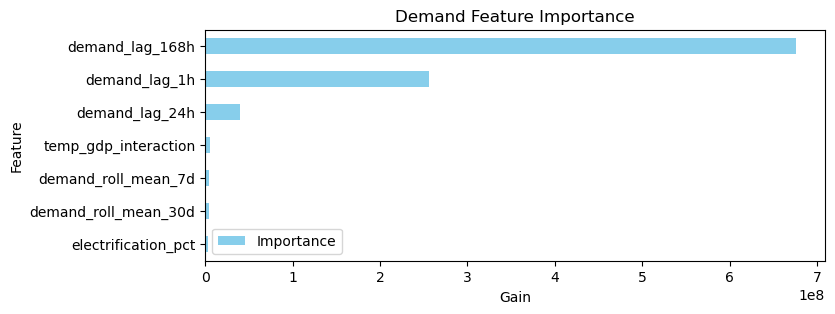

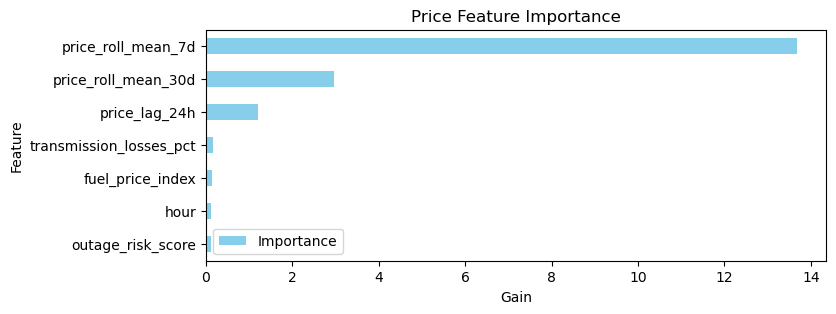

In [41]:
def plot_xgb_importance(model, feature_names, top_n=7, title="XGBoost Feature Importance"):
    # Get feature importance (gain)
    importance = model.get_booster().get_score(importance_type='gain')
    df = pd.DataFrame({
        'Feature': [feature_names[int(f[1:])] for f in importance.keys()],
        'Importance': importance.values()
    }).sort_values('Importance', ascending=False).head(top_n)

    # Plot horizontal bar chart
    df.plot.barh(x='Feature', y='Importance', color='skyblue', figsize=(8,3))
    plt.gca().invert_yaxis()  # largest on top
    plt.title(title)
    plt.xlabel("Gain")
    plt.show()

# Use feature names from your original DataFrame
feature_names = X_train.columns.tolist()

# Plot for demand
plot_xgb_importance(xgb_demand, feature_names, title="Demand Feature Importance")

# Plot for price
plot_xgb_importance(xgb_price, feature_names, title="Price Feature Importance")

In [42]:
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping



# ============================================================================
# MODEL EVALUATION
# ============================================================================

def evaluate_model(model, X_test, y_test, model_type='xgb', lookback=24):
    """
    Evaluate trained XGBoost or LSTM model on test data
    
    Args:
        model: Trained model (XGBoost or LSTM)
        X_test: Test features
        y_test: Test targets
        model_type: 'xgb' or 'lstm'
        lookback: Lookback window for LSTM (ignored for XGBoost)
        
    Returns:
        metrics: Dictionary of evaluation metrics
        y_pred: Model predictions
        y_true: Actual values
    """
    if model_type.lower() == 'xgb':
        y_true = np.asarray(y_test)
        y_pred = model.predict(X_test)

    elif model_type.lower() == 'lstm':
        X_test_seq, y_true = prepare_lstm_data(X_test, y_test, lookback)
        y_pred = model.predict(X_test_seq, verbose=0).flatten()

    else:
        raise ValueError("model_type must be 'xgb' or 'lstm'")

    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    metrics = {
        'MAE': mae, 
        'RMSE': rmse, 
        'R2': r2
    }

    print(f"\n{'='*60}")
    print(f"🧪 TEST SET EVALUATION — {model_type.upper()}")
    print(f"{'='*60}")
    print(f"MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")

    return metrics, y_pred, y_true


# ============================================================================
# TEST SET EVALUATION - ALL MODELS
# ============================================================================

print("\n" + "="*80)
print("🎯 EVALUATING ALL MODELS ON TEST SET")
print("="*80)

# XGBoost - Demand
print("\n📊 DEMAND PREDICTION")
xgb_demand_test_metrics, xgb_demand_pred, y_demand_test_true = evaluate_model(
    xgb_demand,
    X_test_scaled,
    y_demand_test,
    model_type='xgb'
)

# LSTM - Demand
lstm_demand_test_metrics, lstm_demand_pred, y_demand_test_lstm_true = evaluate_model(
    lstm_demand,
    X_test_scaled,
    y_demand_test,
    model_type='lstm',
    lookback=24
)

# XGBoost - Price
print("\n💰 PRICE PREDICTION")
xgb_price_test_metrics, xgb_price_pred, y_price_test_true = evaluate_model(
    xgb_price,
    X_test_scaled,
    y_price_test,
    model_type='xgb'
)

# LSTM - Price
lstm_price_test_metrics, lstm_price_pred, y_price_test_lstm_true = evaluate_model(
    lstm_price,
    X_test_scaled,
    y_price_test,
    model_type='lstm',
    lookback=24
)


# ============================================================================
# SUMMARY COMPARISON
# ============================================================================

print("\n" + "="*80)
print("📈 MODEL COMPARISON SUMMARY")
print("="*80)

print("\n🔋 DEMAND PREDICTION:")
print(f"   XGBoost → MAE: {xgb_demand_test_metrics['MAE']:.4f} | R²: {xgb_demand_test_metrics['R2']:.4f}")
print(f"   LSTM    → MAE: {lstm_demand_test_metrics['MAE']:.4f} | R²: {lstm_demand_test_metrics['R2']:.4f}")

print("\n💵 PRICE PREDICTION:")
print(f"   XGBoost → MAE: {xgb_price_test_metrics['MAE']:.4f} | R²: {xgb_price_test_metrics['R2']:.4f}")
print(f"   LSTM    → MAE: {lstm_price_test_metrics['MAE']:.4f} | R²: {lstm_price_test_metrics['R2']:.4f}")

print("\n" + "="*80)


🎯 EVALUATING ALL MODELS ON TEST SET

📊 DEMAND PREDICTION

🧪 TEST SET EVALUATION — XGB
MAE: 13.2506 | RMSE: 23.5232 | R²: 0.9929

🧪 TEST SET EVALUATION — LSTM
MAE: 73.6627 | RMSE: 173.1297 | R²: 0.6139

💰 PRICE PREDICTION

🧪 TEST SET EVALUATION — XGB
MAE: 0.0139 | RMSE: 0.0196 | R²: 0.9286

🧪 TEST SET EVALUATION — LSTM
MAE: 0.0294 | RMSE: 0.0362 | R²: 0.7568

📈 MODEL COMPARISON SUMMARY

🔋 DEMAND PREDICTION:
   XGBoost → MAE: 13.2506 | R²: 0.9929
   LSTM    → MAE: 73.6627 | R²: 0.6139

💵 PRICE PREDICTION:
   XGBoost → MAE: 0.0139 | R²: 0.9286
   LSTM    → MAE: 0.0294 | R²: 0.7568



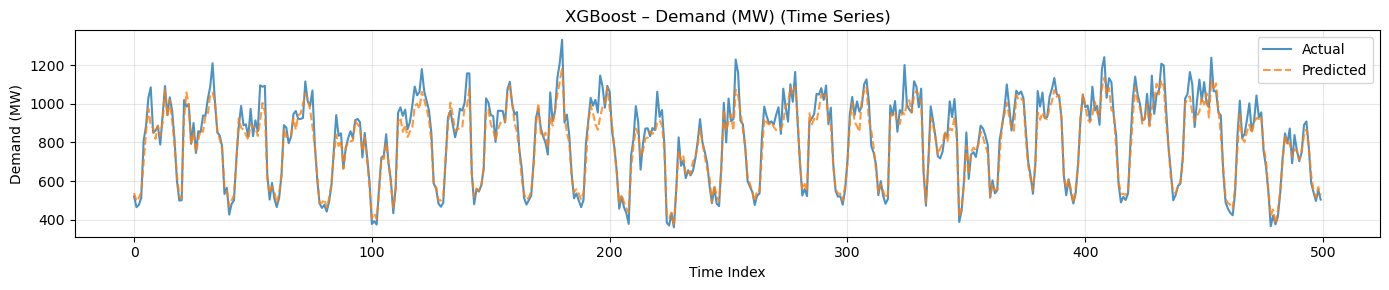

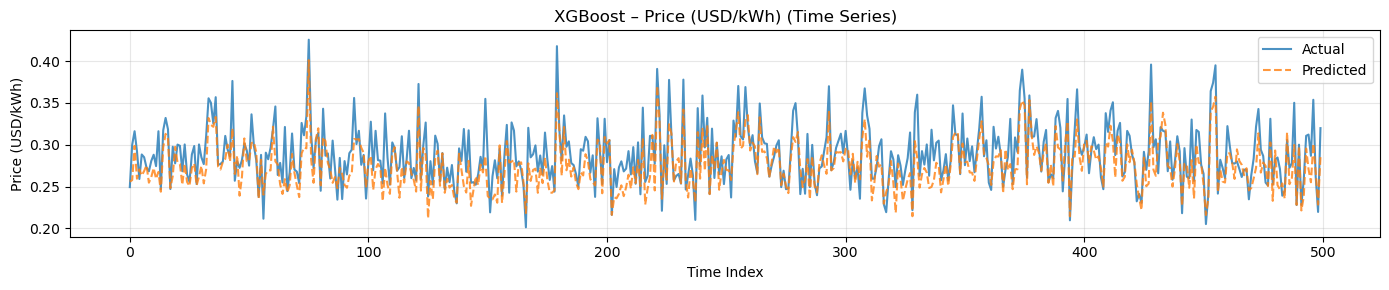

In [43]:
def plot_time_series_predictions(y_true, y_pred, model_name, target_name, sample_size=500):
    """
    Plot only the time series of actual vs predicted values
    for XGBoost or LSTM models.
    """
    # Ensure numpy arrays
    y_true = np.asarray(y_true).flatten()
    y_pred = np.asarray(y_pred).flatten()

    # Limit to sample size
    sample_size = min(sample_size, len(y_true))
    idx = range(sample_size)

    plt.figure(figsize=(14, 3))
    plt.plot(idx, y_true[:sample_size], label="Actual", alpha=0.8)
    plt.plot(idx, y_pred[:sample_size], "--", label="Predicted", alpha=0.8)
    plt.title(f"{model_name} – {target_name} (Time Series)")
    plt.xlabel("Time Index")
    plt.ylabel(target_name)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
# XGBoost – Demand
# XGBoost – Demand
plot_time_series_predictions(
    y_demand_test_true,  # Changed from y_demand_xgb_true
    xgb_demand_pred,
    model_name="XGBoost",
    target_name="Demand (MW)"
)

# XGBoost – Price
plot_time_series_predictions(
    y_price_test_true,  # Changed from y_price_xgb_true
    xgb_price_pred,
    model_name="XGBoost",
    target_name="Price (USD/kWh)"
)

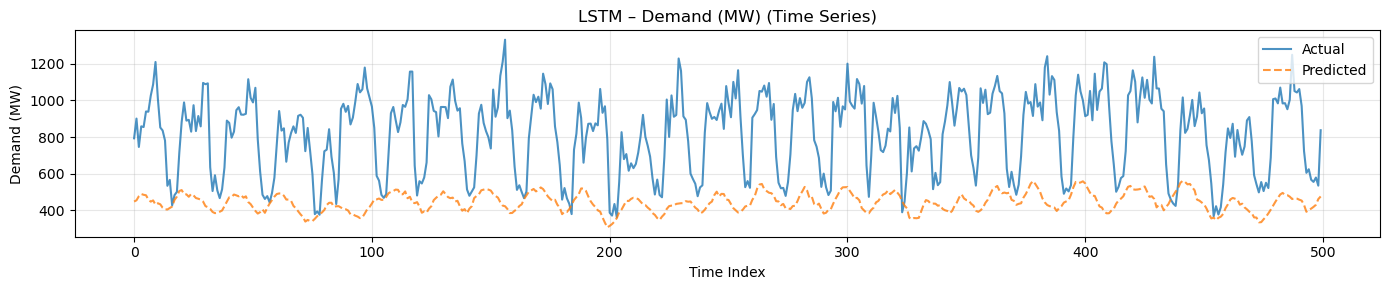

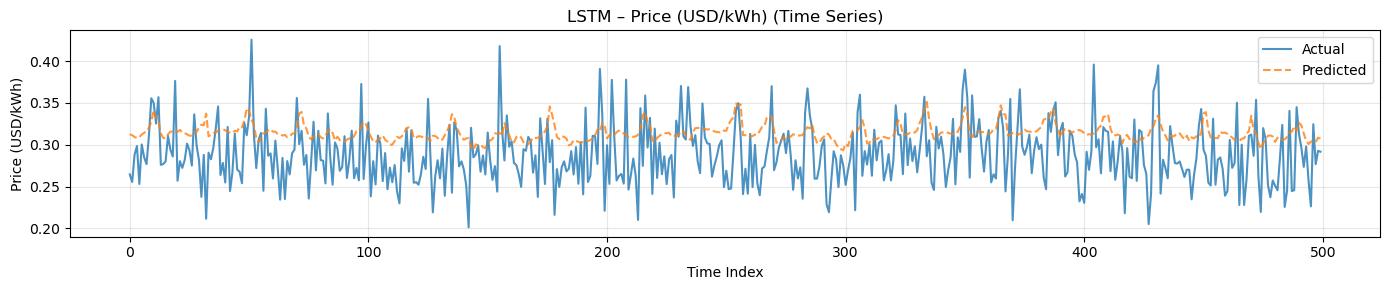

In [44]:
# LSTM – Demand
plot_time_series_predictions(
    y_demand_test_lstm_true,
    lstm_demand_pred,
    model_name="LSTM",
    target_name="Demand (MW)"
)

# LSTM – Price
plot_time_series_predictions(
    y_price_test_lstm_true,
    lstm_price_pred,
    model_name="LSTM",
    target_name="Price (USD/kWh)"
)

In [45]:
def simple_forecast(model, df, scaler, hours=168, country='Nigeria'):
    """
    Simple iterative forecast - one hour at a time
    """
    # Get last 1000 hours of data for the country
    data = df[df['country'] == country].tail(1000).copy()
    last_time = data.index[-1]
    
    forecasts = []
    times = []
    
    print(f"Forecasting {hours} hours from {last_time}...")
    
    for h in range(1, hours + 1):
        next_time = last_time + pd.Timedelta(hours=h)
        
        # Get last row
        last = data.iloc[-1].copy()
        
        # Update time features
        last['hour'] = next_time.hour
        last['month'] = next_time.month
        last['year'] = next_time.year
        last['weekofyear'] = next_time.isocalendar()[1]
        last['is_weeknd'] = 1 if next_time.dayofweek >= 5 else 0
        
        # Update lags from recent history
        last['demand_lag_1h'] = data['demand_mw'].iloc[-1]
        last['demand_lag_24h'] = data['demand_mw'].iloc[-24]
        last['demand_lag_168h'] = data['demand_mw'].iloc[-168]
        last['price_lag_1h'] = data['price_usd_kwh'].iloc[-1]
        last['price_lag_24h'] = data['price_usd_kwh'].iloc[-24]
        
        # Update rolling means
        last['demand_roll_mean_7d'] = data['demand_mw'].iloc[-168:].mean()
        last['demand_roll_mean_30d'] = data['demand_mw'].iloc[-720:].mean()
        last['price_roll_mean_7d'] = data['price_usd_kwh'].iloc[-168:].mean()
        
        # Predict
        features = scaler.feature_names_in_
        X = last[features].values.reshape(1, -1)
        X_scaled = scaler.transform(X)
        pred = model.predict(X_scaled)[0]
        
        # Save
        forecasts.append(pred)
        times.append(next_time)
        
        # Add prediction to data for next iteration
        last['demand_mw'] = pred  # Update with forecast
        last.name = next_time
        data = pd.concat([data, pd.DataFrame([last])])
        
        if h % 24 == 0:
            print(f"  ✓ {h} hours done")
    
    return pd.DataFrame({'timestamp': times, 'forecast': forecasts})

# Run forecasts
print("\n" + "="*80)
print("FORECASTING WITH XGBOOST")
print("="*80)

demand_forecast = simple_forecast(xgb_demand, df, scaler, hours=168, country='Nigeria')
price_forecast = simple_forecast(xgb_price, df, scaler, hours=168, country='Nigeria')

print(f"\n📊 DEMAND: {demand_forecast['forecast'].mean():.1f} MW (avg)")
print(f"💰 PRICE: ${price_forecast['forecast'].mean():.4f}/kWh (avg)")


FORECASTING WITH XGBOOST
Forecasting 168 hours from 2024-12-31 23:00:00...
  ✓ 24 hours done
  ✓ 48 hours done
  ✓ 72 hours done
  ✓ 96 hours done
  ✓ 120 hours done
  ✓ 144 hours done
  ✓ 168 hours done
Forecasting 168 hours from 2024-12-31 23:00:00...
  ✓ 24 hours done
  ✓ 48 hours done
  ✓ 72 hours done
  ✓ 96 hours done
  ✓ 120 hours done
  ✓ 144 hours done
  ✓ 168 hours done

📊 DEMAND: 3568.2 MW (avg)
💰 PRICE: $0.1752/kWh (avg)


In [46]:
def optimize_operations(demand_fc, price_fc):
    """
    Optimize when to buy/sell or charge/discharge based on forecasts
    """
    df = pd.DataFrame({
        'hour': range(len(demand_fc)),
        'demand': demand_fc['forecast'].values,
        'price': price_fc['forecast'].values
    })
    
    # Find cheap and expensive hours
    cheap_threshold = df['price'].quantile(0.25)  # Bottom 25%
    expensive_threshold = df['price'].quantile(0.75)  # Top 25%
    
    df['action'] = 'HOLD'
    df.loc[df['price'] <= cheap_threshold, 'action'] = 'BUY/CHARGE'
    df.loc[df['price'] >= expensive_threshold, 'action'] = 'SELL/DISCHARGE'
    
    # Calculate savings
    avg_price = df['price'].mean()
    buy_price = df[df['action'] == 'BUY/CHARGE']['price'].mean()
    sell_price = df[df['action'] == 'SELL/DISCHARGE']['price'].mean()
    
    savings_pct = ((sell_price - buy_price) / avg_price) * 100
    
    print("\n" + "="*80)
    print("⚡ OPTIMIZATION RESULTS")
    print("="*80)
    print(f"Average Price: ${avg_price:.4f}/kWh")
    print(f"Buy at: ${buy_price:.4f}/kWh")
    print(f"Sell at: ${sell_price:.4f}/kWh")
    print(f"💰 Potential Savings: {savings_pct:.1f}%")
    print(f"\nActions: {df['action'].value_counts().to_dict()}")
    
    return df

# Run optimization
schedule = optimize_operations(demand_forecast, price_forecast)
print("\nFirst 24 hours:")
print(schedule.head(24))


⚡ OPTIMIZATION RESULTS
Average Price: $0.1752/kWh
Buy at: $0.1703/kWh
Sell at: $0.1828/kWh
💰 Potential Savings: 7.1%

Actions: {'HOLD': 74, 'BUY/CHARGE': 52, 'SELL/DISCHARGE': 42}

First 24 hours:
    hour       demand     price          action
0      0  3835.907471  0.177661  SELL/DISCHARGE
1      1  3816.625244  0.178206  SELL/DISCHARGE
2      2  3542.681641  0.179425  SELL/DISCHARGE
3      3  3041.546875  0.181045  SELL/DISCHARGE
4      4  3082.384277  0.179138  SELL/DISCHARGE
5      5  3524.633057  0.177573            HOLD
6      6  3822.017090  0.177573            HOLD
7      7  3810.875977  0.178183  SELL/DISCHARGE
8      8  3811.585449  0.179737  SELL/DISCHARGE
9      9  3533.284668  0.179923  SELL/DISCHARGE
10    10  3489.715332  0.177648  SELL/DISCHARGE
11    11  3547.864990  0.178764  SELL/DISCHARGE
12    12  3539.085693  0.180310  SELL/DISCHARGE
13    13  3859.983398  0.177573            HOLD
14    14  3879.545654  0.177573            HOLD
15    15  3876.766357  0.179737  S

In [47]:
sns.set_style("whitegrid")

def plot_forecast_overview(demand_fc, price_fc, df_original, country='Nigeria'):
    """
    Demand and price forecasts with historical data
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 7))
    
    # Get historical data (last 7 days)
    historical = df_original[df_original['country'] == country].tail(168)
    
    # ===== DEMAND =====
    ax1.plot(historical.index, historical['demand_mw'], 
             'b-', linewidth=2, alpha=0.7, label='Historical')
    ax1.plot(demand_fc['timestamp'], demand_fc['forecast'], 
             'r--', linewidth=2.5, label='Forecast')
    ax1.axvline(x=demand_fc['timestamp'].iloc[0], color='gray', 
                linestyle=':', linewidth=2, alpha=0.5, label='Forecast Start')
    ax1.set_title('Demand Forecast vs Historical', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Demand (MW)', fontsize=12)
    ax1.legend(loc='best', fontsize=11)
    ax1.grid(alpha=0.3)
    
    # ===== PRICE =====
    ax2.plot(historical.index, historical['price_usd_kwh'], 
             'g-', linewidth=2, alpha=0.7, label='Historical')
    ax2.plot(price_fc['timestamp'], price_fc['forecast'], 
             'orange', linestyle='--', linewidth=2.5, label='Forecast')
    ax2.axvline(x=price_fc['timestamp'].iloc[0], color='gray', 
                linestyle=':', linewidth=2, alpha=0.5, label='Forecast Start')
    ax2.set_title('Price Forecast vs Historical', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date & Time', fontsize=12)
    ax2.set_ylabel('Price (USD/kWh)', fontsize=12)
    ax2.legend(loc='best', fontsize=11)
    ax2.grid(alpha=0.3)
    
    plt.suptitle('7-Day Forecast Overview', fontsize=16, fontweight='bold', y=0.995)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def plot_hourly_patterns(demand_fc, price_fc):
    """
    Average demand and price patterns by hour of day
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
    
    # Add hour column
    demand_fc = demand_fc.copy()
    price_fc = price_fc.copy()
    demand_fc['hour'] = demand_fc['timestamp'].dt.hour
    price_fc['hour'] = price_fc['timestamp'].dt.hour
    
    # ===== DEMAND PATTERN =====
    hourly_demand = demand_fc.groupby('hour')['forecast'].agg(['mean', 'std'])
    
    ax1.plot(hourly_demand.index, hourly_demand['mean'], 
             'b-', linewidth=3, marker='o', markersize=10, label='Average Demand')
    ax1.fill_between(hourly_demand.index, 
                      hourly_demand['mean'] - hourly_demand['std'],
                      hourly_demand['mean'] + hourly_demand['std'],
                      alpha=0.3, color='blue', label='±1 Std Dev')
    
    ax1.set_title('Average Demand by Hour of Day', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Hour of Day', fontsize=12)
    ax1.set_ylabel('Demand (MW)', fontsize=12)
    ax1.set_xticks(range(0, 24, 2))
    ax1.legend(loc='best', fontsize=11)
    ax1.grid(alpha=0.3)
    
    # ===== PRICE PATTERN =====
    hourly_price = price_fc.groupby('hour')['forecast'].agg(['mean', 'std'])
    
    ax2.plot(hourly_price.index, hourly_price['mean'], 
             'g-', linewidth=3, marker='s', markersize=10, label='Average Price')
    ax2.fill_between(hourly_price.index, 
                      hourly_price['mean'] - hourly_price['std'],
                      hourly_price['mean'] + hourly_price['std'],
                      alpha=0.3, color='green', label='±1 Std Dev')
    
    ax2.set_title('Average Price by Hour of Day', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Hour of Day', fontsize=12)
    ax2.set_ylabel('Price (USD/kWh)', fontsize=12)
    ax2.set_xticks(range(0, 24, 2))
    ax2.legend(loc='best', fontsize=11)
    ax2.grid(alpha=0.3)
    
    plt.suptitle('Hourly Patterns Analysis', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

def plot_model_comparison(xgb_demand_metrics, lstm_demand_metrics, 
                          xgb_price_metrics, lstm_price_metrics):
    """
    Compare XGBoost vs LSTM for both demand and price
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 6))
    
    models = ['XGBoost', 'LSTM']
    
    # ===== DEMAND - MAE =====
    ax1 = axes[0, 0]
    mae_demand = [xgb_demand_metrics['MAE'], lstm_demand_metrics['MAE']]
    bars1 = ax1.bar(models, mae_demand, color=['steelblue', 'coral'], alpha=0.8)
    ax1.set_title('Demand Prediction - MAE', fontsize=13, fontweight='bold')
    ax1.set_ylabel('MAE', fontsize=11)
    ax1.grid(alpha=0.3, axis='y')
    
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', 
                fontsize=11, fontweight='bold')
    
    # ===== DEMAND - R² =====
    ax2 = axes[0, 1]
    r2_demand = [xgb_demand_metrics['R2'], lstm_demand_metrics['R2']]
    bars2 = ax2.bar(models, r2_demand, color=['steelblue', 'coral'], alpha=0.8)
    ax2.set_title('Demand Prediction - R² Score', fontsize=13, fontweight='bold')
    ax2.set_ylabel('R² Score', fontsize=11)
    ax2.set_ylim([0, 1])
    ax2.grid(alpha=0.3, axis='y')
    
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', 
                fontsize=11, fontweight='bold')
    
    # ===== PRICE - MAE =====
    ax3 = axes[1, 0]
    mae_price = [xgb_price_metrics['MAE'], lstm_price_metrics['MAE']]
    bars3 = ax3.bar(models, mae_price, color=['green', 'orange'], alpha=0.8)
    ax3.set_title('Price Prediction - MAE', fontsize=13, fontweight='bold')
    ax3.set_ylabel('MAE', fontsize=11)
    ax3.grid(alpha=0.3, axis='y')
    
    for bar in bars3:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', 
                fontsize=11, fontweight='bold')
    
    # ===== PRICE - R² =====
    ax4 = axes[1, 1]
    r2_price = [xgb_price_metrics['R2'], lstm_price_metrics['R2']]
    bars4 = ax4.bar(models, r2_price, color=['green', 'orange'], alpha=0.8)
    ax4.set_title('Price Prediction - R² Score', fontsize=13, fontweight='bold')
    ax4.set_ylabel('R² Score', fontsize=11)
    ax4.set_ylim([0, 1])
    ax4.grid(alpha=0.3, axis='y')
    
    for bar in bars4:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', 
                fontsize=11, fontweight='bold')
    
    plt.suptitle('Model Performance Comparison: XGBoost vs LSTM', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()


1️⃣ Generating Forecast Overview...


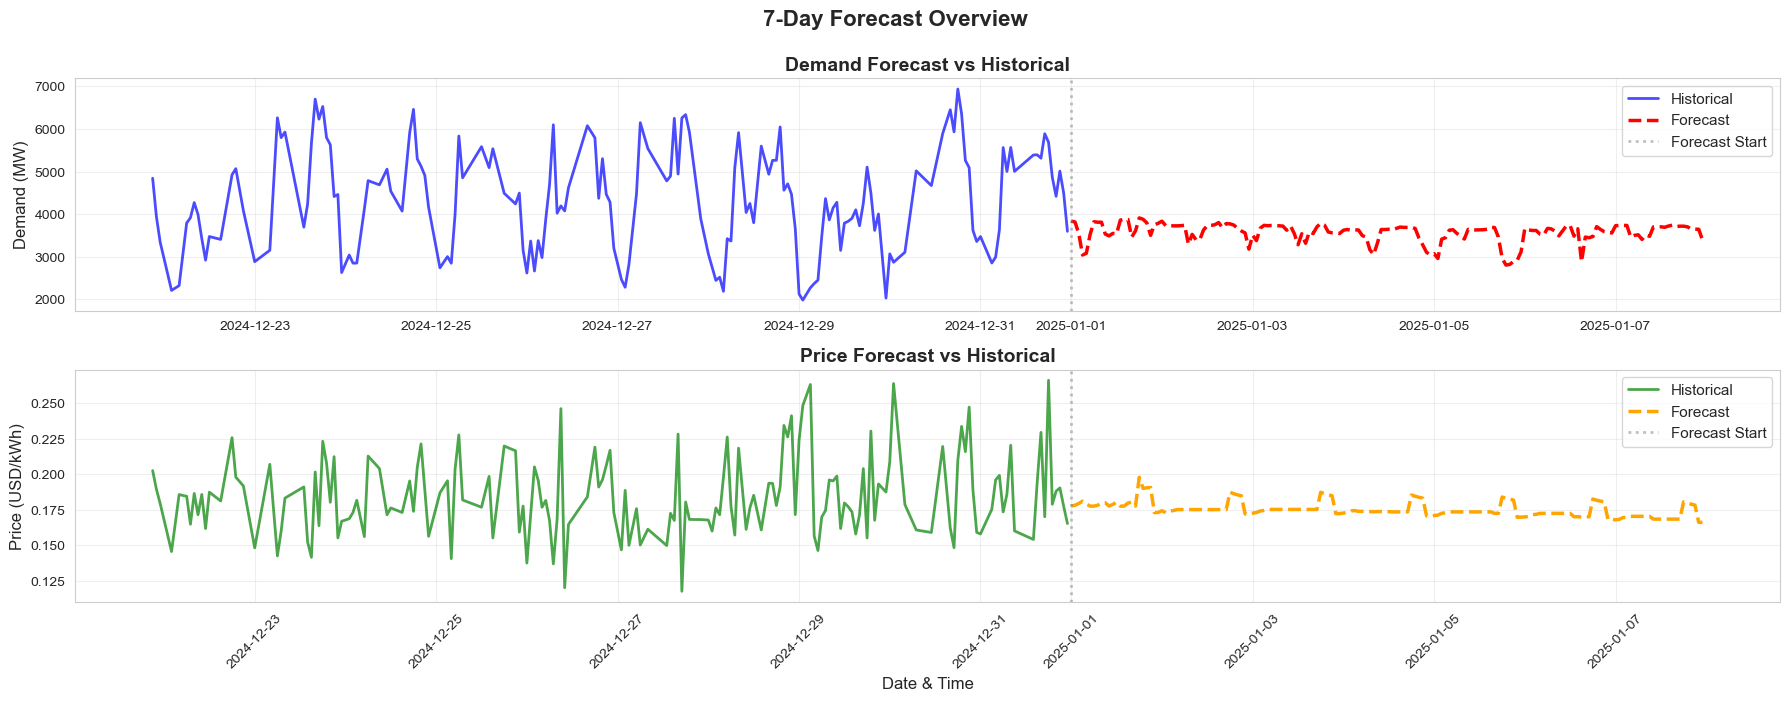

In [48]:
# Forecast visualizations
print("\n1️⃣ Generating Forecast Overview...")
plot_forecast_overview(demand_forecast, price_forecast, df, country='Nigeria')


2️⃣ Generating Hourly Patterns...


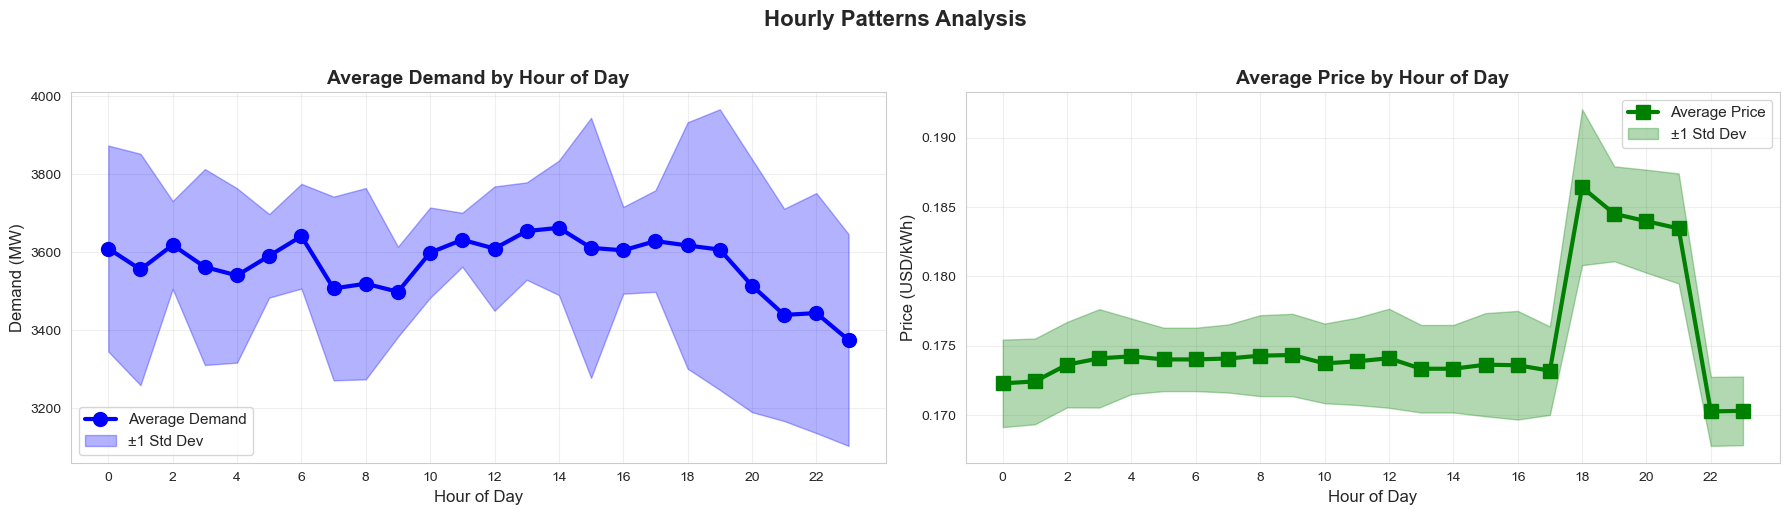

In [49]:
print("\n2️⃣ Generating Hourly Patterns...")
plot_hourly_patterns(demand_forecast, price_forecast)


3️⃣ Generating Model Comparison...


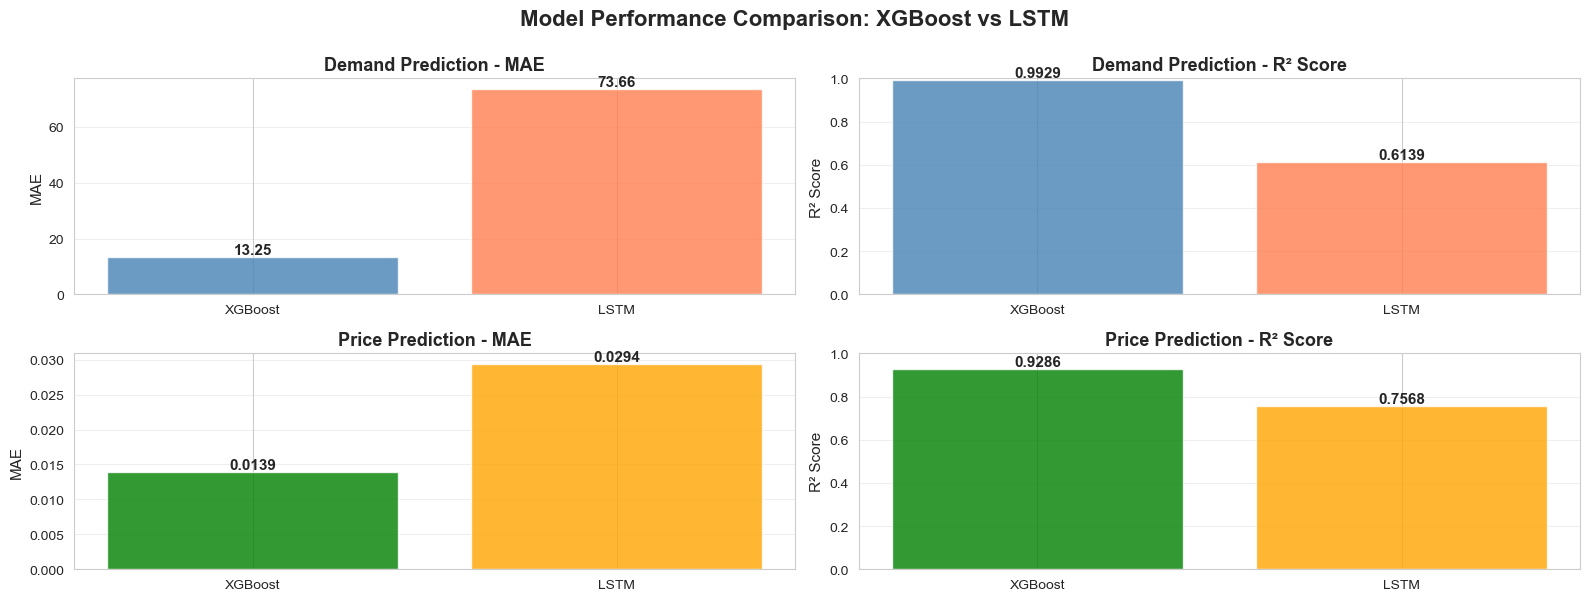

In [50]:
print("\n3️⃣ Generating Model Comparison...")
plot_model_comparison(
    xgb_demand_test_metrics, lstm_demand_test_metrics,
    xgb_price_test_metrics, lstm_price_test_metrics
)


OPTIMIZATION RESULTS

💰 Cost Savings: $-1 (-0.00%)
⚡ Peak Reduction: 0.0 MW
💵 ROI: -0.0% | Payback: -452387.6 years


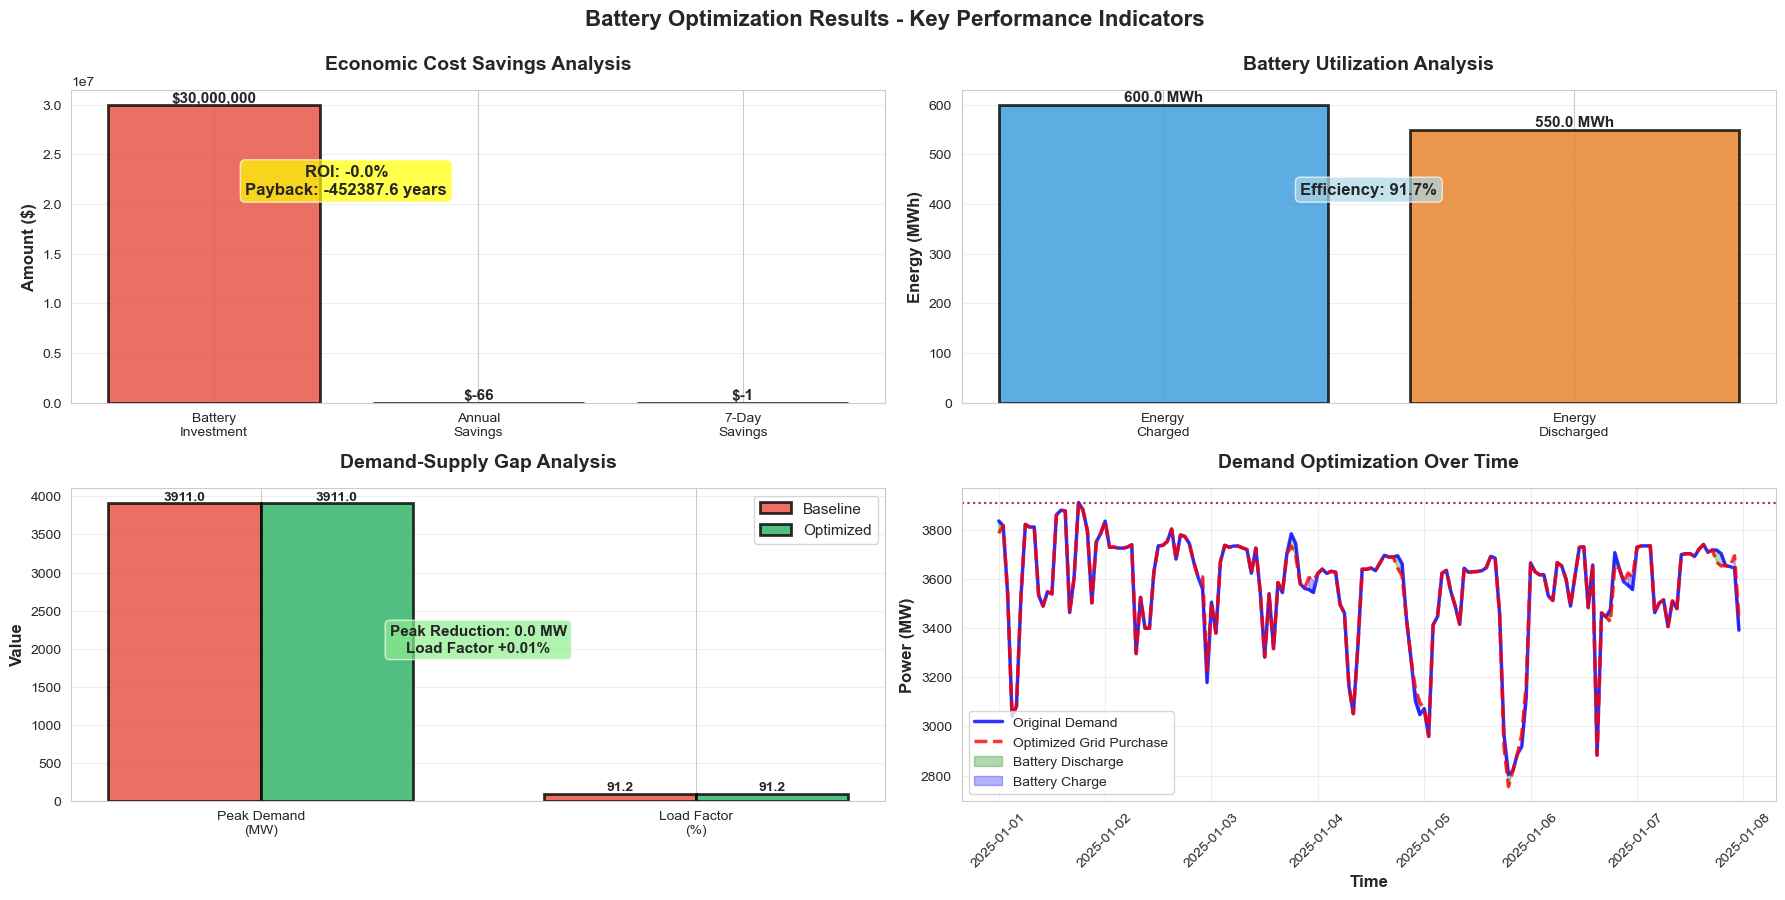

In [51]:
# ============================================================================
# OPTIMIZED VISUALIZATION - FOCUSED ON OPTIMIZATION RESULTS
# ============================================================================

def optimize_battery(demand_fc, price_fc):
    """
    Battery optimization with key metrics
    """
    demand = demand_fc['forecast'].values
    price = price_fc['forecast'].values
    T = len(demand)
    
    # Battery parameters
    capacity = 100  # MWh
    max_rate = 50   # MW
    
    # Initialize
    soc = capacity * 0.5
    charge = np.zeros(T)
    discharge = np.zeros(T)
    grid_buy = np.zeros(T)
    
    # Price thresholds
    low_price = np.percentile(price, 25)
    high_price = np.percentile(price, 75)
    
    # Optimize each hour
    for t in range(T):
        if price[t] <= low_price and soc < capacity:
            charge[t] = min(max_rate, capacity - soc)
            soc += charge[t]
            grid_buy[t] = demand[t] + charge[t]
        elif price[t] >= high_price and soc > 0:
            discharge[t] = min(max_rate, soc)
            soc -= discharge[t]
            grid_buy[t] = max(0, demand[t] - discharge[t])
        else:
            grid_buy[t] = demand[t]
    
    # Metrics
    baseline_cost = np.sum(demand * price)
    optimized_cost = np.sum(grid_buy * price)
    savings = baseline_cost - optimized_cost
    savings_pct = (savings / baseline_cost) * 100
    
    peak_demand = demand.max()
    peak_grid = grid_buy.max()
    peak_reduction = peak_demand - peak_grid
    
    avg_demand = demand.mean()
    avg_grid = grid_buy.mean()
    
    load_factor_baseline = avg_demand / peak_demand
    load_factor_optimized = avg_grid / peak_grid
    load_factor_improvement = load_factor_optimized - load_factor_baseline
    
    battery_cost = capacity * 1000 * 300
    annual_savings = savings * (365/7)
    roi = (annual_savings / battery_cost) * 100
    payback = battery_cost / annual_savings
    
    total_charged = charge.sum()
    total_discharged = discharge.sum()
    
    print("\n" + "="*60)
    print("OPTIMIZATION RESULTS")
    print("="*60)
    print(f"\n💰 Cost Savings: ${savings:,.0f} ({savings_pct:.2f}%)")
    print(f"⚡ Peak Reduction: {peak_reduction:.1f} MW")
    print(f"💵 ROI: {roi:.1f}% | Payback: {payback:.1f} years")
    
    results = pd.DataFrame({
        'timestamp': demand_fc['timestamp'],
        'demand': demand,
        'price': price,
        'charge': charge,
        'discharge': discharge,
        'grid_buy': grid_buy
    })
    
    metrics = {
        'baseline_cost': baseline_cost,
        'optimized_cost': optimized_cost,
        'savings': savings,
        'savings_pct': savings_pct,
        'peak_demand': peak_demand,
        'peak_grid': peak_grid,
        'peak_reduction': peak_reduction,
        'avg_demand': avg_demand,
        'avg_grid': avg_grid,
        'load_factor_baseline': load_factor_baseline,
        'load_factor_optimized': load_factor_optimized,
        'load_factor_improvement': load_factor_improvement,
        'battery_cost': battery_cost,
        'annual_savings': annual_savings,
        'roi': roi,
        'payback': payback,
        'total_charged': total_charged,
        'total_discharged': total_discharged
    }
    
    return results, metrics


# ============================================================================
# RUN OPTIMIZATION
# ============================================================================

results, metrics = optimize_battery(demand_forecast, price_forecast)


# ============================================================================
# VISUALIZATION - 4 KEY OPTIMIZATION PLOTS
# ============================================================================

def plot_optimization_results(results, metrics):
    """
    4-panel visualization showing optimization impact
    """
    fig = plt.figure(figsize=(18, 9))
    
    # ===== 1. COST SAVINGS (Investment vs Annual Savings) =====
    ax1 = plt.subplot(2, 2, 1)
    
    categories = ['Battery\nInvestment', 'Annual\nSavings', '7-Day\nSavings']
    values = [metrics['battery_cost'], metrics['annual_savings'], metrics['savings']]
    colors = ['#e74c3c', '#27ae60', '#3498db']
    
    bars = ax1.bar(categories, values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    ax1.set_ylabel('Amount ($)', fontsize=12, fontweight='bold')
    ax1.set_title('Economic Cost Savings Analysis', fontsize=14, fontweight='bold', pad=15)
    ax1.grid(alpha=0.3, axis='y')
    
    # Add values on bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'${height:,.0f}', ha='center', va='bottom', 
                fontsize=11, fontweight='bold')
    
    # Add ROI and Payback text
    ax1.text(0.5, max(values) * 0.7, 
             f'ROI: {metrics["roi"]:.1f}%\nPayback: {metrics["payback"]:.1f} years',
             ha='center', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
    
    # ===== 2. BATTERY UTILIZATION (Charged vs Discharged) =====
    ax2 = plt.subplot(2, 2, 2)
    
    utilization = [metrics['total_charged'], metrics['total_discharged']]
    labels = ['Energy\nCharged', 'Energy\nDischarged']
    colors_bat = ['#3498db', '#e67e22']
    
    bars = ax2.bar(labels, utilization, color=colors_bat, alpha=0.8, 
                   edgecolor='black', linewidth=2)
    ax2.set_ylabel('Energy (MWh)', fontsize=12, fontweight='bold')
    ax2.set_title('Battery Utilization Analysis', fontsize=14, fontweight='bold', pad=15)
    ax2.grid(alpha=0.3, axis='y')
    
    # Add values on bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f} MWh', ha='center', va='bottom', 
                fontsize=11, fontweight='bold')
    
    # Add efficiency text
    efficiency = (metrics['total_discharged'] / metrics['total_charged']) * 100
    ax2.text(0.5, max(utilization) * 0.7,
             f'Efficiency: {efficiency:.1f}%',
             ha='center', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    # ===== 3. DEMAND-SUPPLY GAP (Peak & Load Factor) =====
    ax3 = plt.subplot(2, 2, 3)
    
    # Create grouped bars
    x = np.arange(2)
    width = 0.35
    
    baseline_vals = [metrics['peak_demand'], metrics['load_factor_baseline'] * 100]
    optimized_vals = [metrics['peak_grid'], metrics['load_factor_optimized'] * 100]
    
    bars1 = ax3.bar(x - width/2, baseline_vals, width, label='Baseline', 
                    color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=2)
    bars2 = ax3.bar(x + width/2, optimized_vals, width, label='Optimized', 
                    color='#27ae60', alpha=0.8, edgecolor='black', linewidth=2)
    
    ax3.set_ylabel('Value', fontsize=12, fontweight='bold')
    ax3.set_title('Demand-Supply Gap Analysis', fontsize=14, fontweight='bold', pad=15)
    ax3.set_xticks(x)
    ax3.set_xticklabels(['Peak Demand\n(MW)', 'Load Factor\n(%)'])
    ax3.legend(fontsize=11)
    ax3.grid(alpha=0.3, axis='y')
    
    # Add values on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='bottom', 
                    fontsize=10, fontweight='bold')
    
    # Add improvement text
    ax3.text(0.5, max(baseline_vals + optimized_vals) * 0.5,
             f'Peak Reduction: {metrics["peak_reduction"]:.1f} MW\n'
             f'Load Factor +{metrics["load_factor_improvement"]*100:.2f}%',
             ha='center', fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
    
    # ===== 4. DEMAND OPTIMIZATION OVER TIME =====
    ax4 = plt.subplot(2, 2, 4)
    
    # Plot demand vs optimized grid purchase
    ax4.plot(results['timestamp'], results['demand'], 
             'b-', linewidth=2.5, label='Original Demand', alpha=0.8)
    ax4.plot(results['timestamp'], results['grid_buy'], 
             'r--', linewidth=2.5, label='Optimized Grid Purchase', alpha=0.8)
    
    # Fill area showing battery contribution
    ax4.fill_between(results['timestamp'], results['grid_buy'], results['demand'],
                      where=(results['demand'] >= results['grid_buy']),
                      alpha=0.3, color='green', label='Battery Discharge')
    ax4.fill_between(results['timestamp'], results['demand'], results['grid_buy'],
                      where=(results['grid_buy'] > results['demand']),
                      alpha=0.3, color='blue', label='Battery Charge')
    
    # Add peak lines
    ax4.axhline(y=metrics['peak_demand'], color='blue', linestyle=':', 
                linewidth=1.5, alpha=0.6)
    ax4.axhline(y=metrics['peak_grid'], color='red', linestyle=':', 
                linewidth=1.5, alpha=0.6)
    
    ax4.set_xlabel('Time', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Power (MW)', fontsize=12, fontweight='bold')
    ax4.set_title('Demand Optimization Over Time', fontsize=14, fontweight='bold', pad=15)
    ax4.legend(loc='best', fontsize=10)
    ax4.grid(alpha=0.3)
    ax4.tick_params(axis='x', rotation=45)
    
    plt.suptitle('Battery Optimization Results - Key Performance Indicators', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()


# Run visualization
plot_optimization_results(results, metrics)